# Methods for Data Science - Coursework 1
## Amaury Francou - CID : 01258326
### amaury.francou16@imperial.ac.uk

<a name="outline"></a>
## Outline

- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear regression
  - [1.2](#q12) Ridge regression
  - [1.3](#q13) Relaxation of Lasso regression
- [Task 2](#task-2): Classification
  - [2.1](#q21) kNN classifier
  - [2.2](#q22) Random forest 
  - [2.3](#q23) Support vector machine (SVM) 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Logistic regression and bagging 
  - [3.2](#q32) Kernelised SVM classifier 

In [539]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import random
from collections import defaultdict
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

<a name="task-1"></a>
# Task 1: Regression [^](#outline)



<a name="q11"></a>

## 1.1 Linear regression  [^](#outline)

We here implement a linear regression model to predict the toxicity factor (LC50) target variable, using all the other features present in the $\texttt{chemistry_samples.csv}$ file dataset as predictors.

We start by visualizing the data :

In [2]:
# Load chemistry data into a pandas dataframe 
df_chemistry = pd.read_csv("chemistry_samples.csv")
# Displaying the first five rows
df_chemistry.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,3.661280,0.658363,1.602232,1.994272,0.836488,3.153623,15.893033,-27.724370,0.059355,0.756698,5.506249
1,3.936362,1.154287,1.146997,0.904295,2.948308,5.141095,13.590177,-31.821521,-13.408855,1.161298,6.636791
2,0.964144,0.415485,1.481028,2.136585,0.043679,-1.156783,15.989419,-3.699312,2.561525,0.500115,1.563388
3,2.074617,1.417296,0.486216,0.000908,-0.066980,2.610960,7.962046,-16.374439,2.448975,1.481888,6.248432
4,1.448569,0.836892,1.951012,0.028318,-0.039121,1.851095,22.285266,-9.526361,2.870400,0.649234,3.676796


In [3]:
# Finding number of samples
nb_samples = df_chemistry['CIC0'].count()
print('Number of samples : ' + str(nb_samples))

Number of samples : 4111


### 1.1.1 Training

We will consider that this given data has been cleaned and pre-processed appropriately, and is further ready for training. The first 10 columns give the 10 predictors and the 11th last column gives the corresponding target variable.

We here consider a regression problem, in the sense of predicting a continuous output (i.e. a quantitative value, by opposition to a categorical output). The loss function that we use in this linear regression is the $\textit{mean squared error}$.

We consider a model $f_{LS}(\mathbf{x}^{(i)},\mathbf{\beta}) = \beta_0 + \beta_1 x_1^{(i)} + \dots + \beta_{10} x_{10}^{(i)}$ where $\mathbf{\beta}$ is an appropriate parameter to be found and the $\mathbf{x}^{(i)}$ are our predictors.

We define an augmented matrix $\mathbf{X}$ containing the descriptor variables in the same way as in the lecture notes. As well, we define a vector $\mathbf{y}$ containing the observed target variables. The solution of the Normal Equation reads : $\mathbf{\beta}^{\star} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$.

In [308]:
# Converting our dataframe to a numpy array
dataArray = df_chemistry.to_numpy()
predictorsArray = df_chemistry.to_numpy()[:,:10]
targetArray = df_chemistry.to_numpy()[:,10]

We build a function that retreives the minimizing beta given an array of predictors and a target value vector :

In [5]:
def getBeta(predictors = predictorsArray, target = targetArray) :
    """
    This function computes a beta vector minimizing the mean squared error upon a linear model, 
    using the closed form solution of the Normal Equation. 

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values

    Returns
    -------
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    """
    
    N, p = predictors.shape # Retreiving shapes
    
    # Building appropriate matrix X
    X = np.zeros(shape = (N,p+1)) 
    X[:,0] = np.ones(N)
    X[:,1:] = predictors
    
    # Computing beta 
    beta = (np.linalg.inv(X.T@X)@X.T)@target
    
    return beta

We further retreive the corresponding beta vector :

In [6]:
beta = getBeta()
print('beta =', beta)

beta = [ 2.61638041e+00  4.47138333e-02  1.25871884e+00 -3.80092766e-02
  3.63073448e-01  4.66534885e-03  3.90510052e-01 -7.46028629e-02
 -3.57069460e-02 -1.52588258e-02 -1.80315940e-03]


We analyze the quality of our model using the coefficient of determination $R^2 = 1 - \frac{\sum (\hat{y}_i - y_i)^2}{\sum (y_i - \bar{y})^2}$, where $y_i$ is the target value, $\hat{y}_i$ is the predicted value and $\bar{y}$ is the mean of all target values. 

We implement a function that computes this coefficient :

In [63]:
def getRsquared(predictors = predictorsArray, target = targetArray, beta = beta, noIntercept = False) :
    """
    This function computes the coefficient of determination of the linear regression.

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    noIntercept : a boolean value - set to True if we use a model in which beta_0 = 0

    Returns
    -------
    Rsquared : a float number - the coefficient of determination
    """
    
    N, p = predictors.shape
    meanTarget = np.mean(target) # Computing the mean of the target values
    
    numerator = 0 # Initializing for the count
    denominator = 0
    
    for i in range(N) : # Computing predictions and building R^2 fraction components
        
        if noIntercept : # No need for augmented vector 
            
            predictedValue = np.dot(beta,predictors[i])

        else :
            # Building augmented x_i
            augmentedPredictor = np.zeros(p+1)
            augmentedPredictor[0] = 1
            augmentedPredictor[1:] = predictors[i]

            # Using our linear model y_i = beta^Tx_i
            predictedValue = np.dot(beta,augmentedPredictor)
        
        # Building R^2 fraction components
        numerator += (target[i] - predictedValue)**2
        denominator += (target[i] - meanTarget)**2
        
    return 1 - (numerator/denominator)
        

In [64]:
# Computing R^2 on the training set 
RsquaredTraining = getRsquared()
print('R^2 =', RsquaredTraining)

R^2 = 0.8718259975718018


### 1.1.2 Testing

We now apply our model $f_{LS}$ to the pre-cleaned testing data that has not been involved in the training phase. The aim is to predict the target variable LC50 of this testing set using the 10 same predictors. We compute the $R^2$ score on this test set.

In [65]:
# Load testing data into a pandas dataframe 
df_chemistry_testing = pd.read_csv("chemistry_test.csv")
# Displaying the first five rows
df_chemistry_testing.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,1.617579,0.376167,1.224281,0.849464,1.101738,-0.448372,14.913614,-9.091450,-1.953849,0.328298,1.791786
1,4.278766,0.514788,1.259734,0.210436,0.819626,4.446118,12.904817,-37.986185,-2.804426,0.452758,6.125609
2,3.578652,0.221018,1.552583,1.007153,-0.013073,1.960720,17.393050,-27.188863,3.565159,0.341665,3.953270
3,3.021762,1.602774,1.044233,0.054776,2.060890,4.510903,12.777434,-22.710306,-7.966119,1.729511,6.995314
4,2.487163,0.799948,1.005727,0.094923,0.146542,2.298082,13.336721,-16.839870,2.607198,0.904353,5.253633


In [66]:
# Finding number of samples
nb_samples = df_chemistry_testing['CIC0'].count()
print('Number of samples : ' + str(nb_samples))

Number of samples : 1028


In [67]:
# Converting our dataframe to a numpy array
testingDataArray = df_chemistry_testing.to_numpy()
predictorsTestingArray = df_chemistry_testing.to_numpy()[:,:10]
targetTestingArray = df_chemistry_testing.to_numpy()[:,10]

In [68]:
# Computing R^2 on the testing set | beta is unchanged
RsquaredTesting = getRsquared(predictors = predictorsTestingArray, target = targetTestingArray, beta = beta) 
print('R^2 =', RsquaredTesting)

R^2 = 0.8642933369927278


We have a slightly smaller $R^2$ computed on the testing set than on the training set. This displays a good generalisability of the model although the linear correlation between the predictors and the target is rather low (86%).  

<a name="q12"></a>
## 1.2 Ridge regression [^](#outline)

We now aim to predict the same target value using the same set of predictors, this time using Ridge regression. We use a 5-fold cross-validation method to find the optimal penalty hyperparameter of the model.

We seek to reduce the number of descriptors by inducing sparsity in our model. We perform this by changing the loss function used. The idea is to maintain some of the coefficients small, by applying small weights.

The loss function involved here is : $L_{RIDGE}(\beta) = ||\mathbf{y}-\mathbf{X}\mathbf{\beta}||^2 + \lambda||\mathbf{\beta}||^2$.

The minimizing beta is $\mathbf{\beta}^{\star} = (\mathbf{X}^T\mathbf{X} + \lambda I)^{-1}\mathbf{X}^T\mathbf{y}$, where $\lambda$ is a hyperparameter. 

Note that here we leave out the intercept $\beta_0$ in the regularization part of the equation, in order to improve the shrinkage of the coefficients and avoid dominating values for said intercept in our linear model.

### 1.2.1 Optimal $\lambda$

To find an optimal $\lambda$, we use a 5-fold cross-validation process. We split our training data into 5 equal subsets. In turn, we then isolate one of the subsets and further train the model on the rest of the training data. We compute the mean squared error of the model, corresponding to predicting the target values of the subset that has been put aside. We repeat this operation for all the 5 subsets. We then compute the mean of mean squared errors, which gives us a measure to find the optimal lambda.

We build relevant helper functions to implement this 5-fold cross-validation method.

We first create a function that computes a minimizing beta, giving the parameter $\lambda$ and the predictors and target.


In [102]:
def getBetaRIDGE(lbda, predictors = dataArray[:,:10], target = dataArray[:,10]) :
    """
    This function computes a beta vector minimizing the mean squared error upon a Ridge 
    regression model.

    Parameters
    ----------
    lbda : a float number - the penalty term
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values

    Returns
    -------
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    """
    
    N, p = predictors.shape # Retreiving shapes
    
    # Building appropriate matrix X
    X = np.zeros(shape = (N,p+1)) 
    X[:,0] = np.ones(N)
    X[:,1:] = predictors
    
    ### We now leave out the intercept ###
    I = np.identity(p+1)
    I[0,0] = 0
    
    # Computing beta 
    beta = (np.linalg.inv(X.T@X + lbda * I)@X.T)@target
    
    return beta

We then build a function that computes the mean squared error of the model.

In [103]:
def MSE(predictors, target, beta) :
    """
    This function computes the mean squared error of the model.

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values
    beta : a p+1-dimensionnal numpy array containing the minimizing beta

    Returns
    -------
    MSE : a float number - the mean squared error of the model
    """
    
    N, p = predictors.shape # Retreiving shapes
    
    S = 0 # Initializing the sum
    
    for i in range(N) : # Computing predictions and mean squared error
        
        # Building augmented x_i
        augmentedPredictor = np.zeros(p+1)
        augmentedPredictor[0] = 1
        augmentedPredictor[1:] = predictors[i]
        
        # Using our linear model y_i = beta^Tx_i
        predictedValue = np.dot(beta,augmentedPredictor)
        
        S += (predictedValue - target[i])**2
        
    return S/N

We finally implement the 5-fold cross-validation process as described previously.

In [314]:
def fiveFoldValidationRIDGE(dataArray, lbda) :
    """
    This function computes the mean of mean squared errors of a five-fold cross-validation process
    for the RIDGE regression model.

    Parameters
    ----------
    lbda : a float number - the penalty term
    dataArray : an Nxp-dimensionnal numpy array containing both the predictors and the target value

    Returns
    -------
    meanMSE : a float number - the mean of mean squared errors of the five-fold cross-validation process
    """
    
    meanSquaredErrors = np.zeros(5) # Container for the mean squared errors
    
    # Building the 5 subsets indexes
    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        # Training
        beta = getBetaRIDGE(lbda = lbda, predictors = trainingSubset[:,:10], target = trainingSubset[:,10])
        # MSE on validation subset
        meanSquaredErrors[i] = MSE(predictors = validationSubset[:,:10], target = validationSubset[:,10], \
                                   beta = beta)
    
    return np.mean(meanSquaredErrors)


We are now able to scan a range of hyperparameters $\lambda$, in order to find one minimizing the mean of mean squared errors over the 5 folds. 

In [315]:
def chooseBestLambdaRIDGE(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter lambda by using a five-fold cross-validation
    method for the RIDGE regression.

    Parameters
    ----------
    dataArray : an Nxp-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of mean squared errors and the tested lambdas 

    Returns
    -------
    best_lambda : a float number - the optimal hyperparameter
    lambdas : an M-dimensionnal numpy array containing the tested lambdas
    lbda_MMSE : an M-dimensionnal numpy array containing the means of MSEs
    best_lambda_ind : an integer - the optimal lambda index in lambdas
    
    """
    # Initialization
    lambdas = np.linspace(start = 1e-15, stop = 1.45, num = 500) # Scanning lambdas
    lbda_MMSE = np.zeros(lambdas.shape[0])
    
    for i, lbda in enumerate(lambdas) :
        # Minimizing mean of MSE
        lbda_MMSE[i] = fiveFoldValidationRIDGE(dataArray = dataArray, lbda = lbda)
        if i%50 == 0 : # Prints from time to time
            print('Cross-validation for lambda = ' + str(lbda) + ' gives a mean of MSE = ' + str(lbda_MMSE[i]))
        
    best_lambda_ind = np.argmin(lbda_MMSE) # A minimizer of means of MSEs
    
    if returnArray :
        return lambdas[best_lambda_ind], lambdas, lbda_MMSE, best_lambda_ind
    
    return lambdas[best_lambda_ind]

In [316]:
# Computing optimal lambda
bestLambdaRIDGE, lambdas, lbda_MMSE,\
best_lambda_ind = chooseBestLambdaRIDGE(dataArray = dataArray, returnArray = True)

Cross-validation for lambda = 1e-15 gives a mean of MSE = 0.18792876597652347
Cross-validation for lambda = 0.14529058116232554 gives a mean of MSE = 0.18792795031638843
Cross-validation for lambda = 0.2905811623246501 gives a mean of MSE = 0.18792732584088223
Cross-validation for lambda = 0.4358717434869746 gives a mean of MSE = 0.18792689014630146
Cross-validation for lambda = 0.5811623246492992 gives a mean of MSE = 0.18792664086084016
Cross-validation for lambda = 0.7264529058116237 gives a mean of MSE = 0.18792657564412468
Cross-validation for lambda = 0.8717434869739482 gives a mean of MSE = 0.18792669218675254
Cross-validation for lambda = 1.0170340681362728 gives a mean of MSE = 0.18792698820982445
Cross-validation for lambda = 1.1623246492985975 gives a mean of MSE = 0.18792746146449585
Cross-validation for lambda = 1.3076152304609219 gives a mean of MSE = 0.18792810973155943


We compute this optimal $\lambda$ and report the corresponding mean of mean squared errors : 

In [317]:
# Optimal lambda hyperparameter RIDGE
print('Optimal λ = ' + str(bestLambdaRIDGE))
# Corresponding mean of MSEs
print('Minimum mean of MSEs = ' + str(lbda_MMSE[best_lambda_ind]))

Optimal λ = 0.7061122244488982
Minimum mean of MSEs = 0.18792657378004998


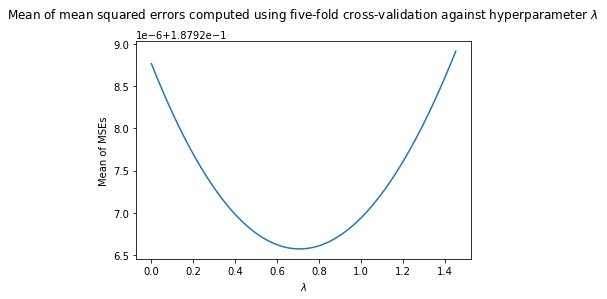

In [318]:
# RIDGE : Plotting mean of MSEs against different lambdas
plt.figure()
title = 'Mean of mean squared errors computed using five-fold cross-validation against hyperparameter $\lambda$ \n'
plt.title(title)
plt.xlabel('$\lambda$')
plt.ylabel('Mean of MSEs')
plt.plot(lambdas,lbda_MMSE)

Our optimal $\lambda \approx 0.70$ well minimizes the mean of MSEs.

The method used is a regularization method where high components in $\beta$ are penalized. It is intended to reduce overfitting by limiting the importance of unrelevant and covariates inputs. The $\lambda$ term controls the magnitude of this penalty. 

For $\lambda = 0$ we retreive the linear regression. As $\lambda$ grows, the coefficients of $\beta$ will shrink accordingly, reducing the impact of unrelevant entry variables on the model, further lowering the variance but increasing the bias. This method exchanges bias against variance. A tradeoff $\lambda$ is found using our cross-validation process.

### 1.2.2 Comparing $R^2$

We now use our optimal $\lambda$ to compute the vector $\beta$ on the entire data set. We further compute the related coefficient of determination $R^2$. We compare it with the corresponding score computed on the unused testing set.

In [119]:
# Training on full dataset - RIDGE Regression
betaRIDGE = getBetaRIDGE(lbda = bestLambdaRIDGE, predictors = dataArray[:,:10], target = dataArray[:,10]) 
print('beta_RIDGE = ',betaRIDGE)

beta_RIDGE =  [ 2.61821445  0.04433401  1.25230457 -0.03780147  0.36279609  0.00495367
  0.39065473 -0.07463672 -0.03570967 -0.01524778  0.00319929]


In [121]:
# Computing R^2 with best lambda and on full data set
RsquaredTrainingRIDGE = getRsquared(predictors = dataArray[:,:10], target = dataArray[:,10], \
                                    beta = betaRIDGE)
print('R^2 with RIDGE on full data set = ',RsquaredTrainingRIDGE)
print('Previous R^2 =', RsquaredTraining)
print('Difference =', RsquaredTrainingRIDGE - RsquaredTraining)

R^2 with RIDGE on full data set =  0.8718250436593374
Previous R^2 = 0.8718259975718018
Difference = -9.53912464352058e-07


In [123]:
# Computing R^2 with best lambda and on testing data set
RsquaredTestingRIDGE = getRsquared(predictors = testingDataArray[:,:10], target = testingDataArray[:,10],\
                                   beta = betaRIDGE)
print('R^2 with RIDGE on testing set = ',RsquaredTestingRIDGE)
print('Previous R^2 =', RsquaredTesting)
print('Difference =', RsquaredTestingRIDGE - RsquaredTesting)

R^2 with RIDGE on testing set =  0.8642791908122764
Previous R^2 = 0.8642933369927278
Difference = -1.4146180451368728e-05


The linear correlation is moderately worse using ridge regression, as there is a difference of order $10^{-6}$ in the coefficient of determination, both on training and testing set. The shrinkage method used - here with a small penalty term that well balances variance and bias - does not allow to improve our model's predictions. In our considered case, a linear method may not be capable of modelling the perhaps more subtil relationship that exists between our predictors and our target.


<a name="q13"></a>

## 1.3 Relaxation of Lasso regression  [^](#outline)

We now consider another shrinkage method : a relaxation of the Lasso optimisation. Namely, we now aim to minimize $L_{LASSO} = ||\mathbf{y}-\mathbf{X}\beta||^2 + \lambda \sum_i^p L_c(\beta_i)$, where the 1-norm is replaced by the use of smooth Huber functions $L_c$ defined by :$$L_c(\beta)=\begin{cases}\frac{1}{2}\beta^2 \text{ if $|\beta|\leq c$}\\c(|\beta|-\frac{1}{2}c) \text{ otherwise}\end{cases}$$ This formulation makes the error function differentiable, and further allows the use of the gradient descent algorithm. The parameter $c$ is here fixed.

### 1.3.1 Computing the gradient

In order to perform the algorithm, we compute the gradient of the objective function :$$ \nabla L_{LASSO}(\beta) = -2\mathbf{X}^T(\mathbf{y}-\mathbf{X}\beta)+ \lambda\sum_i^p\frac{dL_c(\beta_i)}{d\beta}\vec{\mathbf{e}}_i \text{ with - as long as $c>0$ - }\frac{dL_c(\beta_i)}{d\beta}=\begin{cases}\beta_i \text{ if $|\beta_i|\leq c$} \\c\frac{\beta_i}{|\beta_i|}\text{ otherwise}\end{cases}$$ 

We implement those functions and gradients in the following.


In [186]:
def huber(beta, c=1e-6) :
    """
    This function computes the regularization term of the relaxed LASSO method.

    Parameters
    ----------
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    c : a float number - a fixed parameter of Huber functions

    Returns
    -------
    huberTerm : a float number - the regularization term
    """
    
    p = beta.shape[0] - 1 # Retreiving the number of parameters
    Lcs = np.zeros(p+1)
    
    for i in range(p+1) : # Using Lc formula
        if np.abs(beta[i]) <= c :
            Lcs[i] = 0.5 * beta[i]**2
        else :
            Lcs[i] = c * (np.abs(beta[i]) - 0.5 * c)
            
    return np.sum(Lcs) 



def LASSOfunc(predictors, target, beta, lbda, c=1e-6) :
    """
    This function computes the objective function of the relaxed LASSO method.

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    lbda : a float number - the penalty term
    c : a float number - a fixed parameter of Huber functions

    Returns
    -------
    L : a float number - the value of the objective function
    """
        
    N, p = predictors.shape # Retreiving shapes
    
    # Building appropriate matrix X
    X = np.zeros(shape = (N,p+1)) 
    X[:,0] = np.ones(N)
    X[:,1:] = predictors
    
    # Using formula
    L = np.linalg.norm(target - X@beta)**2 + lbda * huber(beta, c=c)
    
    return L
    
def grad_huber(beta, c=1e-6) :
    """
    This function computes the gradient of the regularization term of the relaxed LASSO method.

    Parameters
    ----------
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    c : a float number - a fixed parameter of Huber functions

    Returns
    -------
    huberTermGradient : a p+1-dimensionnal numpy array - the regularization term gradient
    """
    p = beta.shape[0] - 1 # Retreiving the number of parameters
    dLcs = np.zeros(p+1)
    
    for i in range(p+1) : # Using dLc/dB formula
        if np.abs(beta[i]) <= c :
            dLcs[i] = beta[i]
        else :
            dLcs[i] = c * beta[i]/np.abs(beta[i])
            
    return dLcs

def gradLASSO(predictors, target, beta, lbda, c=1e-6) :
    """
    This function computes the gradient of the objective function of the relaxed LASSO method.

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values
    beta : a p+1-dimensionnal numpy array containing the minimizing beta
    lbda : a float number - the penalty term
    c : a float number - a fixed parameter of Huber functions

    Returns
    -------
    grad : a p+1-dimensionnal numpy array - the gradient of the objective function
    """
    
    N, p = predictors.shape # Retreiving shapes
    
    # Building appropriate matrix X
    X = np.zeros(shape = (N,p+1)) 
    X[:,0] = np.ones(N)
    X[:,1:] = predictors
    
    # Using analytical expression with scaling
    grad = -2 * (X.T/N)@(target - X@beta) + lbda * grad_huber(beta, c=1e-6)
    
    return grad

We now implement the gradient descent algorithm using fixed step size, to compute a vector $\beta$ minimizing our objective function $L_{LASSO}$.

In [187]:
def gradientDescentHuber(predictors, target, lbda, initialGuess = np.array([]), step = 1e-9, maxIt = 100000, \
                         tol = 1e-4, c = 1e-6, printPath = False) :
    """
    This function computes the beta vector minimizing the objective function of the relaxed LASSO method,
    using gradient descent.

    Parameters
    ----------
    predictors : an Nxp-dimensionnal numpy array containing the predictors
    target : an N-dimensionnal numpy array containing the target values
    lbda : a float number - the penalty term
    initialGuess : a p+1-dimensionnal numpy array - an initial guess for beta - defaulted to zero-vector
    step : a float number - the stepsize of the gradient descent
    maxIt : an integer - the maximum number of iteration used 
    tol : a float number - a tolerance for the gradient norm of the searched minimizing beta
    c : a float number - a fixed parameter of Huber functions
    printPath : a boolean value - if set to True the function prints the path taken by the optimization process

    Returns
    -------
    beta : a p+1-dimensionnal numpy array - a beta minimizing the objective function
    it : an integer - the number of iterations needed
    """
    
    N, p = predictors.shape # Retreiving shapes
    
    it = 0
    
    if initialGuess.shape[0] == 0 :
        beta = np.zeros(p+1) # Default initial guess
    
    else :
        beta = initialGuess
        
    for i in range(maxIt) :
        
        it += 1
        
        # Computing gradient
        grad = gradLASSO(predictors = predictors, target = target, beta = beta, lbda = lbda, c = c)
        gradNorm = np.linalg.norm(grad)
        
        if gradNorm < tol : # We arrived at a stationary point for given tolerance
            break
        
        # Otherwise descent in the steepest direction
        beta = beta - step * grad
        
        if printPath :
            if i%(int(0.0025 * maxIt)) == 0 : # Prints from time to time 
                score = LASSOfunc(predictors = predictors, target = target, beta = beta, lbda = lbda, c = c)
                print('Iteration ' + str(it) + ' | Function = ' + str(score) + \
                      ' | Gradient Norm = ' + str(gradNorm))
        
    return beta, it

In [188]:
# Testing gradient descent
gradientDescentHuber(predictors = dataArray[:,:10], target = dataArray[:,10], \
                      lbda = 0.6, step = 1e-3, maxIt = 10000000, tol = 1e-5, \
                         c = 1e-6, printPath = True)

Iteration 1 | Function = 28442.378959477992 | Gradient Norm = 227.75490382111786
Iteration 25001 | Function = 830.424658999481 | Gradient Norm = 0.036279485132313785
Iteration 50001 | Function = 775.1844743713776 | Gradient Norm = 0.012610316646409759
Iteration 75001 | Function = 768.0425521098945 | Gradient Norm = 0.004785049935000894
Iteration 100001 | Function = 766.9711351830725 | Gradient Norm = 0.0019128563798617815
Iteration 125001 | Function = 766.795754931298 | Gradient Norm = 0.0007878749380624969
Iteration 150001 | Function = 766.7655810608005 | Gradient Norm = 0.0003302272927778618
Iteration 175001 | Function = 766.7602358427371 | Gradient Norm = 0.0001399123353415887
Iteration 200001 | Function = 766.7592716999577 | Gradient Norm = 5.9702761418182735e-05
Iteration 225001 | Function = 766.7590958773776 | Gradient Norm = 2.5601027484080937e-05
Iteration 250001 | Function = 766.7590636622168 | Gradient Norm = 1.1015526426888262e-05


(array([ 2.61614876e+00,  4.47752378e-02,  1.25879634e+00, -3.81497307e-02,
         3.63076934e-01,  4.66848449e-03,  3.90507450e-01, -7.45834813e-02,
        -3.57030878e-02, -1.52566764e-02, -1.83963849e-03]),
 252874)

In [189]:
# We pre-computed a 'good' beta minimizer to get quicker convergence 
# (This works even if there is a dependence on lambda)
# We use this initial guess
initialBeta = np.array([ 2.61614876e+00,  4.47752378e-02,  1.25879634e+00, -3.81497307e-02,
         3.63076934e-01,  4.66848449e-03,  3.90507450e-01, -7.45834813e-02,
        -3.57030878e-02, -1.52566764e-02, -1.83963849e-03])


gradientDescentHuber(predictors = dataArray[:,:10], target = dataArray[:,10], initialGuess = initialBeta, \
                      lbda = 0.05, step = 1e-3, maxIt = 10000000, tol = 1e-7, \
                         c = 1e-6, printPath = True)

Iteration 1 | Function = 766.7590597190107 | Gradient Norm = 9.985721146600064e-06
Iteration 25001 | Function = 766.7590549000959 | Gradient Norm = 4.231356969772427e-06
Iteration 50001 | Function = 766.7590540150468 | Gradient Norm = 1.822314550042831e-06
Iteration 75001 | Function = 766.7590538519114 | Gradient Norm = 7.867052342195796e-07
Iteration 100001 | Function = 766.7590538220902 | Gradient Norm = 3.4013851444302373e-07
Iteration 125001 | Function = 766.7590538167935 | Gradient Norm = 1.472084748134433e-07


(array([ 2.61637769e+00,  4.47142739e-02,  1.25871876e+00, -3.80099546e-02,
         3.63073468e-01,  4.66533839e-03,  3.90510088e-01, -7.46027082e-02,
        -3.57069269e-02, -1.52588058e-02, -1.80265209e-03]),
 136551)

### 1.3.2 Finding optimal $\lambda$

We again use a 5-fold cross-validation process to find an optimal $\lambda$ hyperparameter. We scan a range of possible lambdas computing the mean of mean squared errors, in order to find a suitable minimizer.

In [319]:
def fiveFoldValidationLASSO(dataArray, lbda, initialGuess = initialBeta) :
    """
    This function computes the mean of mean squared errors of a five-fold cross-validation 
    of the relaxed LASSO regression model.

    Parameters
    ----------
    lbda : a float number - the penalty term
    dataArray : an Nxp-dimensionnal numpy array containing both the predictors and the target value
    initialGuess : a p+1-dimensionnal numpy array - an initial guess for beta - defaulted to our pre-computed
        'best bet'

    Returns
    -------
    meanMSE : a float number - the mean of mean squared errors of the five-fold cross-validation 
    """
    
    meanSquaredErrors = np.zeros(5) # Container for the mean squared errors
    
    # Building the 5 subsets indexes
    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        # Training
        beta, _ = gradientDescentHuber(predictors = trainingSubset[:,:10], target = trainingSubset[:,10], \
                                    initialGuess = initialGuess, \
                      lbda = lbda, step = 1e-3, maxIt = 1000, tol = 1e-4, \
                         c = 1e-6, printPath = False)
        # MSE on validation subset
        meanSquaredErrors[i] = MSE(predictors = validationSubset[:,:10], target = validationSubset[:,10], \
                                   beta = beta)
    
    return np.mean(meanSquaredErrors)


In [320]:
def chooseBestLambdaLASSO(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter lambda by using a five-fold cross-validation
    method for the relaxed LASSO regression.

    Parameters
    ----------
    dataArray : an Nxp-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of mean squared errors and the tested lambdas 

    Returns
    -------
    best_lambda : a float number - the optimal hyperparameter
    lambdas : an M-dimensionnal numpy array containing the tested lambdas
    lbda_MMSE : an M-dimensionnal numpy array containing the means of MSEs
    best_lambda_ind : an integer - the optimal lambda index in lambdas
    
    """
    # Initialization
    lambdas = np.linspace(start = 0.01, stop = 3400, num = 150) # Scanning lambdas
    lbda_MMSE = np.zeros(lambdas.shape[0])
    
    for i, lbda in enumerate(lambdas) :
        # Minimizing mean of MSE
        lbda_MMSE[i] = fiveFoldValidationLASSO(dataArray = dataArray, lbda = lbda)
        if i%25 == 0 : # Prints from time to time
            print('Cross-validation for lambda = ' + str(lbda) + ' gives a mean of MSE = ' + str(lbda_MMSE[i]))
        
    best_lambda_ind = np.argmin(lbda_MMSE) # A minimizer of means of MSEs
    
    if returnArray :
        return lambdas[best_lambda_ind], lambdas, lbda_MMSE, best_lambda_ind
    
    return lambdas[best_lambda_ind]

In [321]:
# Computing optimal lambda for LASSO
bestLambdaLASSO, lambdas, lbda_MMSE, best_lambda_ind \
 = chooseBestLambdaLASSO(dataArray = dataArray, returnArray = True)

Cross-validation for lambda = 0.01 gives a mean of MSE = 0.1875322390984032
Cross-validation for lambda = 570.478120805369 gives a mean of MSE = 0.18753209357249018
Cross-validation for lambda = 1140.946241610738 gives a mean of MSE = 0.1875311307787258
Cross-validation for lambda = 1711.4143624161072 gives a mean of MSE = 0.1875307346404845
Cross-validation for lambda = 2281.8824832214764 gives a mean of MSE = 0.1875302241046819
Cross-validation for lambda = 2852.3506040268453 gives a mean of MSE = 0.18753053819813637


In [322]:
# Optimal lambda hyperparameter for LASSO
print('Optimal λ = ' + str(bestLambdaLASSO))
# Corresponding mean of MSEs
print('Minimum mean of MSEs = ' + str(lbda_MMSE[best_lambda_ind]))

Optimal λ = 2327.519932885906
Minimum mean of MSEs = 0.18753018726076942


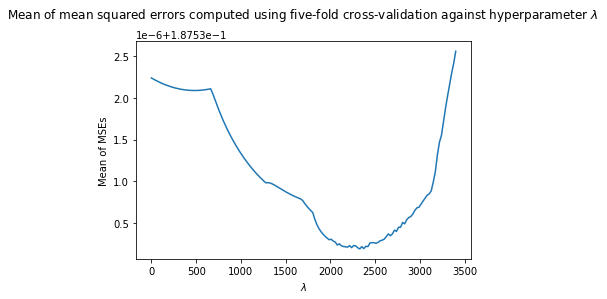

In [323]:
# Plotting mean of MSEs against different lambdas : LASSO
plt.figure()
title = 'Mean of mean squared errors computed using five-fold cross-validation against hyperparameter $\lambda$ \n'
plt.title(title)
plt.xlabel('$\lambda$')
plt.ylabel('Mean of MSEs')
plt.plot(lambdas,lbda_MMSE)

We have an optimal hyperparameter that is $\lambda\approx 2327.51$. We now compute the $R^2$ score for a $\beta$ vector obtained on the full data set. We also compute the score on the unused testing data set, using the optimal $\lambda$. 

In [202]:
# Training on full dataset - LASSO Regression
betaLASSO, _ = gradientDescentHuber(predictors = dataArray[:,:10], target = dataArray[:,10], lbda = bestLambdaLASSO, \
                     initialGuess = initialBeta, step = 1e-3, maxIt = 100000, \
                         tol = 1e-7, c = 1e-6, printPath = False)
print('beta_LASSO = ',betaLASSO)

beta_LASSO =  [ 2.59244275e+00  3.70541093e-02  1.25512614e+00 -2.51006000e-03
  3.61845960e-01  1.81569736e-03  3.94104704e-01 -7.61873140e-02
 -3.65516622e-02 -1.54841140e-02  7.22181153e-07]


In [203]:
# Computing R^2 with best lambda on full data set
RsquaredTrainingLASSO = getRsquared(predictors = dataArray[:,:10], target = dataArray[:,10], \
                                    beta = betaLASSO)
print('R^2 with LASSO on full data set = ',RsquaredTrainingLASSO)
print('Previous (Linear Regression) R^2 =', RsquaredTraining)
print('Difference =', RsquaredTrainingLASSO - RsquaredTraining)

R^2 with LASSO on full data set =  0.8717725639585844
Previous (Linear Regression) R^2 = 0.8718259975718018
Difference = -5.343361321741291e-05


In [206]:
# Computing R^2 with best lambda on testing data set
RsquaredTestingLASSO = getRsquared(predictors = testingDataArray[:,:10], target = testingDataArray[:,10],\
                                   beta = betaLASSO)
print('R^2 with LASSO on testing set = ',RsquaredTestingLASSO)
print('Previous (Linear Regression) R^2 =', RsquaredTesting)
print('Difference =', RsquaredTestingLASSO - RsquaredTesting)

R^2 with LASSO on testing set =  0.8641651128285768
Previous (Linear Regression) R^2 = 0.8642933369927278
Difference = -0.0001282241641510362


### 1.3.2 Comparing regression coefficients

We analyze the different $\beta$ obtained with the relaxed LASSO method and the Ridge regression method. 

In [212]:
# Comparing beta of LASSO and RIDGE regression
print('Coefficients of LASSO : ',betaLASSO)
print('')
print('Coefficients of RIDGE : ',betaRIDGE)
print('')
print('Norm of beta RIDGE - Norm of beta LASSO = ', np.linalg.norm(betaRIDGE) - np.linalg.norm(betaLASSO))

Coefficients of LASSO :  [ 2.59244275e+00  3.70541093e-02  1.25512614e+00 -2.51006000e-03
  3.61845960e-01  1.81569736e-03  3.94104704e-01 -7.61873140e-02
 -3.65516622e-02 -1.54841140e-02  7.22181153e-07]

Coefficients of RIDGE :  [ 2.61821445  0.04433401  1.25230457 -0.03780147  0.36279609  0.00495367
  0.39065473 -0.07463672 -0.03570967 -0.01524778  0.00319929]

Norm of beta RIDGE - Norm of beta LASSO =  0.021574597198687595


As said previously, both method used here are shrinkage methods that incite coefficients to be small. As Ridge regression will constrain some coefficients to be small-scale but not zero, the Lasso method will enforce many coefficients to be zero, leaving some other non-zero entries (for instance see the difference between $\beta^{RIDGE}_{11}\approx 0.003$ and $\beta^{LASSO}_{11}\approx 10^{-7}$).

Both methods reduce accuracy on the training set. However, Ridge regression will lower overfitting and provide a better generalizability of the model, while the Lasso method will better select a minimum set of non-covariate predictors that correlate best with the target, thus informing the user on the underlying phenomenon at stake.

<a name="task-2"></a>

# Task 2: Classification [^](#outline)

<a name="q21"></a>

## 2.1 kNN classifier [^](#outline)

Our goal here is to predict a 2-classes categorical output based on a 30-features input. This classification task is made to predict the diagnosis of breast tumour samples as ‘benign’ ('B') or ‘malignant’ ('M'). We use features and targets available in the $\texttt{tumour_samples.csv}$ dataset file. 

We start by visualizing the data :

In [213]:
# Load tumour data into a pandas dataframe 
df_tumour = pd.read_csv("tumour_samples.csv")
# Displaying the first five rows
df_tumour.head()

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,0,10.855170,15.248290,69.167041,359.534878,0.105488,0.080200,0.066410,0.034194,0.182796,...,18.984557,81.443134,466.879302,0.149080,0.200185,0.205695,0.111592,0.335999,0.093477,B
1,1,10.068958,15.532758,66.130635,330.040665,0.099813,0.109540,0.057583,0.023322,0.195650,...,22.840293,82.133171,473.367822,0.125478,0.330466,0.283304,0.088021,0.312882,0.096158,B
2,2,12.271409,18.100314,78.195610,421.537832,0.105147,0.095315,0.043317,0.031539,0.188801,...,26.365608,84.598334,620.586067,0.146766,0.118707,0.147900,0.050402,0.291805,0.069556,B
3,3,10.531733,18.452486,67.227069,340.063033,0.086041,0.049961,0.049709,0.011046,0.203093,...,24.385385,73.296855,429.675600,0.100060,0.143683,0.177225,0.028111,0.287749,0.073174,B
4,4,12.367686,14.399191,80.643814,460.849710,0.106410,0.101420,0.020806,0.021990,0.195326,...,19.614305,89.910502,472.323112,0.138135,0.276127,0.151098,0.074396,0.345258,0.095830,B


In [216]:
# Finding number of samples
nb_samples = df_tumour['n1_radius'].count()
print('Number of samples : ' + str(nb_samples))

Number of samples : 2566


### 2.1.1 Training the k-NN

For a new entry feature variable $\mathbf{x}_i\in\mathbb{R}^{30}$, this method computes its $k$-nearest-neigbors in the training set - here in the sense of the euclidian norm - and further uses the majority rule upon the classes of said neigbors to provide a predicted class for this unseen inputed variable. 

We will here also consider that the training set has been cleaned and pre-processed accordingly.

In the following, we build a set of functions to implement this method and we use a 5-fold cross-validation process to find the optimal hyperparameter $k$. 

In [375]:
# Converting our dataframe to a numpy array
dataArray = df_tumour.to_numpy()
# Standardization
dataArray[:,1:31] = (dataArray[:,1:31] - np.mean(dataArray[:,1:31])) / np.std(dataArray[:,1:31])

In [376]:
def getNeighbors(inputFeatures, k, predictors = dataArray) :
    """
    This function computes the indexes of the k-nearest-neighbors of the inputFeatures vector in the
    predictors array, with respect to the euclidean distance.

    Parameters
    ----------
    inputFeatures : a p-dimensionnal numpy array - the input vector for which we compute the neighbors
    k : an integer - the number of neighbors searched for
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value - an 
        identifier index is also set at the begining of the rows 

    Returns
    -------
    neighborsIndexes : a k-dimensionnal numpy array - the indexes of the k-closest neighbors
    """
    distances = np.zeros(len(predictors)) # Initializing
    
    for ind, predictor in enumerate(predictors) :
        distances[ind] = 1 / np.linalg.norm(predictor[1:31] - inputFeatures) # Computing all distances 
        # We will look for the argmax - we thus take 1/distance
    
    neighborsIndexes = np.argpartition(distances, -k)[-k:] # Indexes of k lowest distances
        
    return neighborsIndexes

In [377]:
def kNN(inputFeatures, k, predictors = dataArray) :
    """
    This function computes a prediction for the inputFeatures vector, based on the majority rule 
    applied to its k-nearest-neighbors.
    
    Parameters
    ----------
    inputFeatures : a p-dimensionnal numpy array - the input vector for which we compute the prediction
    k : an integer - the number of neighbors
    predictors : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value - an 
        identifier index is also set at the begining of the rows 

    Returns
    -------
    prediction : a string or an integer - the prediction - -1 is returned if the majority rule cannot be applied
    """
    
    # Computing nearest neighbors
    neighborsIndexes = getNeighbors(inputFeatures, k, predictors) 
    neighbors = predictors[neighborsIndexes]
    
    # Counting the number of 'M' and 'B' classes in the neighbors 
    nbM = list(neighbors[:,31]).count('M')
    nbB = list(neighbors[:,31]).count('B')
    
    # Majority rule
    if nbM > nbB :
        return 'M'
    elif nbB > nbM :
        return 'B'
    else : # If the number of 'M' equals the number of 'B' we abandon the prediction 
        return -1

To compute the optimal $k$ by using the cross-validation method, we here measure accuracy, that is to say the proportion of correct predictions made over the validation set. 

In [378]:
def fiveFoldValidationKNN(dataArray, k) :
    """
    This function computes the mean of accuracies of a five-fold cross-validation process made
    on the KNN model.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    k : an integer - the number of neighbors

    Returns
    -------
    meanAccuracy : a float number - the mean of accuracies of the five-fold cross-validation 
    """
    
    accuracies = np.zeros(5) # Container for the accuracies

    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        
        accuracy = 0
        # Training and Validation
        for inputFeatures in validationSubset :
            prediction = kNN(inputFeatures = inputFeatures[1:31], k = k, predictors = trainingSubset)
            if prediction != -1 : # Ties are considered as a missed prediction here 
                if prediction == inputFeatures[31] :
                    accuracy += 1
        accuracies[i] = accuracy / len(validationSubset)
    
    return np.mean(accuracies)

In [379]:
def chooseBestK(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter k by using a five-fold cross-validation
    method for the kNN model.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of accuracies and the tested k 

    Returns
    -------
    best_k : a integer - the optimal hyperparameter
    kList : an M-dimensionnal numpy array containing the tested k
    meanAccuracies : an M-dimensionnal numpy array containing the means of accuracies
    best_k_ind : an integer - the optimal k index in kList
    
    """
    # Initialization
    kList = np.arange(start = 1, stop = 8, step = 1) # Scanning k
    meanAccuracies = np.zeros(kList.shape[0])
    
    for i, k in enumerate(kList) :
        # Maximizing mean of accuracies
        meanAccuracies[i] = fiveFoldValidationKNN(dataArray = dataArray, k = k)
        print('Cross-validation for k = ' + str(k) + ' gives a mean of accuracies = ' + str(meanAccuracies[i]))
        
    best_k_ind = np.argmax(meanAccuracies) # A maximizer of accuracies 
    
    if returnArray :
        return kList[best_k_ind], kList, meanAccuracies, best_k_ind
    
    return kList[best_k_ind]

In [380]:
# Computing optimal k for KNN
bestK, kList, meanAccuracies, best_k_ind \
 = chooseBestK(dataArray = dataArray, returnArray = True)

Cross-validation for k = 1 gives a mean of accuracies = 0.9586744639376217
Cross-validation for k = 2 gives a mean of accuracies = 0.9391812865497075
Cross-validation for k = 3 gives a mean of accuracies = 0.9629629629629628
Cross-validation for k = 4 gives a mean of accuracies = 0.9536062378167642
Cross-validation for k = 5 gives a mean of accuracies = 0.9614035087719298
Cross-validation for k = 6 gives a mean of accuracies = 0.9551656920077972
Cross-validation for k = 7 gives a mean of accuracies = 0.9614035087719298


In [381]:
# Optimal k hyperparameter for kNN
print('Optimal k = ' + str(bestK))
# Corresponding mean of MSEs
print('Maximum mean of accuracies = ' + str(meanAccuracies[best_k_ind]))

Optimal k = 3
Maximum mean of accuracies = 0.9629629629629628


### 2.1.2 Computing accuracies

We compute the accuracies of our model having fixed $k$ to an optimum ($k=3$), on both the training and the unseen testing set. 

In [386]:
def accuracyKNN(testingArray, k, trainingArray = dataArray) :
    """
    This function computes the accuracy of the KNN model, trained on the dataArray.

    Parameters
    ----------
    testingArray : an Nx(p+2)-dimensionnal numpy array contain containing both the predictors and 
        the target value of the testing set 
    k : an integer - the number of neighbors
    trainingArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and 
        the target value of the training set 

    Returns
    -------
    accuracy : a float number - the accuracy of the model
    """
    
    accuracy = 0
    
    # Training and Testing
    for inputFeatures in testingArray :
        prediction = kNN(inputFeatures = inputFeatures[1:31], k = k, predictors = trainingArray)
        if prediction != -1 : # Ties are considered as a missed prediction here 
            if prediction == inputFeatures[31] :
                accuracy += 1
    accuracy = accuracy / len(testingArray)
    
    return accuracy

In [394]:
# Computing accuracy on full training data 
accuracyTraining = accuracyKNN(testingArray = dataArray, k = bestK)
print('Accuracy on full training data = ' + str(accuracyTraining))

Accuracy on full training data = 0.975448168355417


In [389]:
# Load testing tumour data into a pandas dataframe 
df_tumour_test = pd.read_csv("tumour_test.csv")
# Displaying the first five rows
df_tumour_test.head()

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,0,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,...,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090,M
1,1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,...,34.23,91.29,632.9,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788,B
2,2,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,...,19.31,96.53,688.9,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710,B
3,3,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,...,25.26,105.80,819.7,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676,B
4,4,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,B


In [390]:
# Finding number of samples
nb_samples = df_tumour_test['n1_radius'].count()
print('Number of samples : ' + str(nb_samples))

Number of samples : 200


In [391]:
# Converting our dataframe to a numpy array
testingDataArray = df_tumour_test.to_numpy()
# Standardization
testingDataArray[:,1:31] = (testingDataArray[:,1:31] - \
                            np.mean(testingDataArray[:,1:31])) / np.std(testingDataArray[:,1:31])

In [396]:
# Computing accuracy on unseen testing data 
accuracyTesting = accuracyKNN(testingArray = testingDataArray, k = bestK)
print('Accuracy on unseen testing data = ' + str(accuracyTesting))

Accuracy on unseen testing data = 0.875


We observe that the accuracy computed on the testing set is rather smaller than the one computed on the training set. Unsurprisingly, the model's attempts to predict unseen data are less likely to be valid, however the accuracy remains high (87%), specially considering the small amount of data available in the testing file (200 samples), on which said score has been computed.

<a name="q22"></a>

## 2.2 Random forest [^](#outline)

We use a random forest method to perform a classification task on the same data set of tumour samples. Namely, we build decision trees that succesively split the input variable space by minimizing the $\textit{cross-entropy}$ function, further partionning said space. We then use a majority rule to obtain a probability vector describing the chances a given input has from belonging to a specific class.

We randomly sample our training set and generate $B$ decision trees, which outcomes are aggregated to produce our prediction. Moreover, the splits building our decision trees are made minimizing cross-entropy over a random sample of possible predictors to be chosen for the operation (feature bagging).

In the following, we build several helper functions to perform this task.

### 2.2.1 Training 

We use the same 5-fold cross-validation process to fix the number of trees and tree-depth hyperparameters. We use accuracy to measure the performance of the model.

As the implementation becomes more complex, we now heavily $\textbf{rely on the weekly coding tasks solutions}$, and further $\textbf{modify them to suit our current problem}$. 

In [481]:
# In the weekly Coding Task solution functions, you may find my custom comments in the form of ### _____ ###

# CT solution introduce the possibility of setting non uniform sample weights
# We won't consider this case here
uniform_weights = np.ones(dataArray.shape[0]) / dataArray.shape[0]

In [491]:
## MODIFYING CT6 SOLUTIONS ## 

### Gini-index modified to cross-entropy ###
def cross_entropy(y, sample_weights = uniform_weights):
  """ 
  Calculate the cross-entropy for labels.
  Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the cross-entropy for y.
  """

  ### Weights are uniform here ### 

  # count different labels in y，and store in label_weights
  # initialize with zero for each distinct label.
  label_weights = {yi: 0 for yi in set(y)}  
  for yi, wi in zip(y, sample_weights):
      label_weights[yi] += wi

  total_weight = sum(label_weights.values())

  ### We now use the cross-entropy formula ### 
  CE = 0 
  for label, weight in label_weights.items():
      probability = (weight / total_weight)
      CE += probability * np.log(probability)

  return -CE

In [490]:
# Trying cross-entropy over the entire data set
print('CE = ', cross_entropy(y = dataArray[:,31]))

CE =  0.4482540468603776


In [492]:
## NOT MODIFYING THIS CT6 SOLUTION FUNCTION ## 

def split_samples(X, y, sample_weights, column, value, categorical):
  """
  Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
  """ 

  if categorical:
    left_mask =(X[:, column] == value)
  else:
    left_mask = (X[:, column] < value)
  
  X_left, X_right = X[left_mask, :], X[~left_mask, :]
  y_left, y_right = y[left_mask], y[~left_mask]
  w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

  return (X_left, X_right), (y_left, y_right), (w_left, w_right)

In [493]:
## MODIFYING CT6 SOLUTIONS ## 
### Now using cross-entropy ###

def CE_split_value(X, y, sample_weights, column, categorical):
  """
  Calculate the cross-entropy based on `column` with the split that minimizes the cross-entropy.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      (float, float): the resulted cross-entropy and the corresponding value used in splitting.
  """
  
  unique_vals = np.unique(X[:, column])

  assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

  CE_val, threshold = np.inf, None
  
  # split the values of i-th feature and calculate the cost 
  for value in unique_vals:
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical) 

    # if one of the two sides is empty, skip this split.
    if len(y_l) == 0 or len(y_r) == 0:
      continue
    
    ### Now using cross-entropy ###
    p_left = sum(w_l)/(sum(w_l) + sum(w_r))
    p_right = 1 - p_left
    new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
    
    if new_cost < CE_val:
      CE_val, threshold = new_cost, value
    
  return CE_val, threshold

In [494]:
# Trying out a split on x_5
CE_split_value(X = dataArray[:,1:31], y = dataArray[:,31], sample_weights = uniform_weights, \
               column = 5, categorical = False)

(0.3461197233140173, -0.27976282172399447)

In [495]:
## NOT MODIFYING THIS CT6 SOLUTION FUNCTION ## 

def CE_split(X, y, sample_weights, columns_dict):
  """
  Choose the best feature to split according to criterion.
  Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      (int, float): the best feature index and value used in splitting. 
      If the feature index is None, then no valid split for the current Node.
  """

  
  min_CE, split_column, split_val = np.inf, None, 0
  for column, categorical in columns_dict.items():
      # skip column if samples are not seperable by that column.
      if len(np.unique(X[:, column])) < 2:
        continue
      CE, val = CE_split_value(X, y, sample_weights, column, categorical)      
      if CE < min_CE:
          min_CE, split_column, split_val = CE, column, val

  return split_column, split_val

In [497]:
## NOT MODIFYING THIS CT6 SOLUTION FUNCTION ## 

def CE_split_rf(n_features, X, y, sample_weights, columns_dict):
  """
  Choose the best feature to split according to criterion.
  Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      (float, int, float): the minimized cross-entropy, the best feature index and value used in splitting.
  """
  columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
  columns_dict = {c: columns_dict[c] for c in columns}

  min_CE, split_column, split_val = np.inf, 0, 0
  for column, categorical in columns_dict.items():
    # skip column if samples are not seperable by that column.
    if len(np.unique(X[:, column])) < 2:
      continue

    # search for the best splitting value for the given column.
    CE, val = CE_split_value(X, y, sample_weights, column, categorical)      
    if CE < min_CE:
        min_CE, split_column, split_val = CE, column, val

  return min_CE, split_column, split_val

In [499]:
# All predictors are continuous in our case 
columns_dict = {index: False for index in range(dataArray[:,1:31].shape[1])}

# Trying the split - Which descriptor is best to perform the split on, what is the threshold ?
split_column, split_val = CE_split(X = dataArray[:,1:31], \
                                   y = dataArray[:,31], sample_weights = uniform_weights,\
                                   columns_dict = columns_dict)

print('Predictor index to perform the split on = ',split_column)
print('Threshold = ',split_val)

Predictor index to perform the split on =  22
Threshold =  0.3614633428241891


In [500]:
# Which descriptor is best if we try splits on a random set of descriptors ?
# What is the corresonding threshold ?
_ , split_column, split_val = CE_split_rf(n_features = 10, X = dataArray[:,1:31], \
                                   y = dataArray[:,31], sample_weights = uniform_weights,\
                                   columns_dict = columns_dict)
print('Predictor index to perform the split on = ',split_column)
print('Threshold = ',split_val)

Predictor index to perform the split on =  3
Threshold =  3.5793188329304426


In [501]:
## NOT MODIFYING THIS CT6 SOLUTION FUNCTION ## 

def majority_vote(y, sample_weights):
  """
  Return the label which appears the most in y.
  Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the majority label
  """
  majority_label = {yi: 0 for yi in set(y)}

  for yi, wi in zip(y, sample_weights):
    majority_label[yi] += wi
  return max(majority_label, key=majority_label.get)

In [528]:
## SLIGHTLY MODIFYING THIS CT6 SOLUTION FUNCTION ## 
### Dropping feature name ###


def build_tree_rf(n_features, X, y, sample_weights, \
                  columns_dict, depth,  max_depth=10, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
  if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  else:
    CE, split_index, split_val = CE_split_rf(n_features, X, y, sample_weights, columns_dict)
    
    # If CE is infinity, it means that samples are not seperable by the sampled features.
    if CE == np.inf:
      return {'majority_label': majority_vote(y, sample_weights)}
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
    return {
        'feature_index': split_index, ### Dropping feature name ###
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, depth + 1, max_depth, min_samples_leaf)
    }

In [551]:
# Trying tree generation
tree = build_tree_rf(n_features = 5, X = dataArray[:,1:31], y = dataArray[:,31], sample_weights = uniform_weights,\
                  columns_dict = columns_dict, depth = 1,  max_depth=10, min_samples_leaf=2)
tree

{'feature_index': 27,
 'value': -0.279510198052512,
 'categorical': False,
 'majority_label': None,
 'left': {'feature_index': 13,
  'value': -0.09145766210249551,
  'categorical': False,
  'majority_label': None,
  'left': {'feature_index': 0,
   'value': -0.19479106778623373,
   'categorical': False,
   'majority_label': None,
   'left': {'feature_index': 22,
    'value': 0.29935126648984833,
    'categorical': False,
    'majority_label': None,
    'left': {'feature_index': 18,
     'value': -0.28024820848257287,
     'categorical': False,
     'majority_label': None,
     'left': {'feature_index': 7,
      'value': -0.28002689373704853,
      'categorical': False,
      'majority_label': None,
      'left': {'feature_index': 23,
       'value': 3.952424768602475,
       'categorical': False,
       'majority_label': None,
       'left': {'majority_label': 'B'},
       'right': {'feature_index': 3,
        'value': 2.6409421582238193,
        'categorical': False,
        'majority_

In [573]:
## MODIFYING CT6 SOLUTIONS ## 

### Inserting max_depth as an argument for cross-validation ###
def train_rf(B, max_depth, n_features, X, y,  columns_dict = columns_dict, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      B: number of decision trees.
      max_depth: maximum depth of the trees
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  N = X.shape[0]
  training_indices = np.arange(N)
  trees = []

  for _ in range(B):
    sample = np.random.choice(training_indices, N, replace=True)
    X_sample = X[sample, :]
    y_sample = y[sample]
    w_sample = sample_weights[sample]
    tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, depth=1,\
                         max_depth=max_depth) ### Maximum depth is no more defaulted to 10 here ###
    trees.append(tree)

  return trees

In [536]:
## NOT MODIFYING THOSE CT6 SOLUTION FUNCTIONS ## 

def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['majority_label'] is not None: 
    return tree['majority_label']

  elif tree['categorical']:
    if x[tree['feature_index']] == tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

  else:
    if x[tree['feature_index']] < tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)


def predict_rf(rf, X):
  """
  Predict classification results for X.
  Args:
      rf: A trained random forest through train_rf function.
      X: testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """

  def aggregate(decisions):
    count = defaultdict(int)
    for decision in decisions:
      count[decision] += 1
    return max(count, key=count.get)

  if len(X.shape) == 1:
      return aggregate([classify(tree, X) for tree in rf])
  else:
      return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

### Using accuracy ###
def rf_score(rf, X_test, y_test):
  y_pred = predict_rf(rf, X_test) 
  return np.mean(y_pred==y_test)

We now perform the 5-fold cross-validation as previously. 

In [591]:
def fiveFoldValidationRF(dataArray, max_depth, B) :
    """
    This function computes the mean of accuracies of a five-fold cross-validation process
    on the random forests model.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    max_depth : an integer - the maximum depth of the trees
    B : an integer - the number of trees

    Returns
    -------
    meanAccuracy : a float number - the mean of accuracies of the five-fold cross-validation 
    """
    
    accuracies = np.zeros(5) # Container for the accuracies

    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        
        # Training and Validation
        # On training subset
        rf = train_rf(B = B, max_depth = max_depth, n_features = 10, X = trainingSubset[:,1:31],\
              y = trainingSubset[:,31]) 
        # On validation subset
        accuracies[i] = rf_score(rf = rf, X_test = validationSubset[:,1:31], y_test = validationSubset[:,31])
         
    
    return np.mean(accuracies)

In [602]:
def chooseBestParamsRF(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter max_depth and B by using a five-fold cross-validation
    method for the random forests model.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of accuracies and the tested max_depth and B

    Returns
    -------
    best_maxDepth : a integer - the optimal max-depth hyperparameter
    best_B : a integer - the optimal B hyperparameter
    maxDepthList : an M-dimensionnal numpy array containing the tested max_depth
    BList : an N-dimensionnal numpy array containing the tested B
    meanAccuracies : an NxM-dimensionnal numpy array containing the means of accuracies
    best_maxDepth_ind : an integer - the optimal max_depth index in maxDepthList
    best_B_ind : an integer - the optimal B index in BList
    
    
    """
    # Initialization
    BList = np.arange(start = 2, stop = 10 , step = 3) # Scanning B
    maxDepthList = np.arange(start = 4, stop = 14, step = 4) # Scanning max_depth
    meanAccuracies = np.zeros((BList.shape[0],maxDepthList.shape[0])) # Storing accuracies
    
    for i, B in enumerate(BList) :
        for j, max_depth in enumerate(maxDepthList) :
            # Maximizing mean of accuracies
            meanAccuracies[i,j] = fiveFoldValidationRF(dataArray, max_depth, B)
            print('Cross-validation for B = ' + str(B) + ' and max_depth = ' + str(max_depth) + \
                  ' gives a mean of accuracies = ' + str(meanAccuracies[i,j]))
        
    best_B_ind, best_maxDepth_ind  = np.where(meanAccuracies == np.amax(meanAccuracies))
    # A maximizer of accuracies
    best_B_ind = best_B_ind[0]
    best_maxDepth_ind = best_maxDepth_ind[0]
    
    if returnArray :
        return BList[best_B_ind], maxDepthList[best_maxDepth_ind], BList, maxDepthList, \
    meanAccuracies, best_B_ind, best_maxDepth_ind
    
    return BList[best_B_ind], maxDepthList[best_maxDepth_ind]

In [605]:
# Computing the optimal parameters 
bestB, bestMaxDepth, BList, maxDepthList, \
    meanAccuracies, best_B_ind, best_maxDepth_ind = chooseBestParamsRF(dataArray, returnArray = True)

Cross-validation for B = 5 and max_depth = 8 gives a mean of accuracies = 0.9801169590643275
Cross-validation for B = 5 and max_depth = 9 gives a mean of accuracies = 0.9828460038986355
Cross-validation for B = 5 and max_depth = 10 gives a mean of accuracies = 0.9840155945419102
Cross-validation for B = 5 and max_depth = 11 gives a mean of accuracies = 0.9828460038986353
Cross-validation for B = 5 and max_depth = 12 gives a mean of accuracies = 0.9808966861598438
Cross-validation for B = 6 and max_depth = 8 gives a mean of accuracies = 0.9824561403508772
Cross-validation for B = 6 and max_depth = 9 gives a mean of accuracies = 0.9840155945419102
Cross-validation for B = 6 and max_depth = 10 gives a mean of accuracies = 0.9847953216374268
Cross-validation for B = 6 and max_depth = 11 gives a mean of accuracies = 0.983625730994152
Cross-validation for B = 6 and max_depth = 12 gives a mean of accuracies = 0.9812865497076023
Cross-validation for B = 7 and max_depth = 8 gives a mean of accu

In [610]:
### Very long wall time - Saving the variables here ###

# Cross-validation for B = 5 and max_depth = 8 gives a mean of accuracies = 0.9801169590643275
# Cross-validation for B = 5 and max_depth = 9 gives a mean of accuracies = 0.9828460038986355
# Cross-validation for B = 5 and max_depth = 10 gives a mean of accuracies = 0.9840155945419102
# Cross-validation for B = 5 and max_depth = 11 gives a mean of accuracies = 0.9828460038986353
# Cross-validation for B = 5 and max_depth = 12 gives a mean of accuracies = 0.9808966861598438
# Cross-validation for B = 6 and max_depth = 8 gives a mean of accuracies = 0.9824561403508772
# Cross-validation for B = 6 and max_depth = 9 gives a mean of accuracies = 0.9840155945419102
# Cross-validation for B = 6 and max_depth = 10 gives a mean of accuracies = 0.9847953216374268
# Cross-validation for B = 6 and max_depth = 11 gives a mean of accuracies = 0.983625730994152
# Cross-validation for B = 6 and max_depth = 12 gives a mean of accuracies = 0.9812865497076023
# Cross-validation for B = 7 and max_depth = 8 gives a mean of accuracies = 0.9832358674463937
# Cross-validation for B = 7 and max_depth = 9 gives a mean of accuracies = 0.9793372319688108
# Cross-validation for B = 7 and max_depth = 10 gives a mean of accuracies = 0.9847953216374268
# Cross-validation for B = 7 and max_depth = 11 gives a mean of accuracies = 0.983625730994152
# Cross-validation for B = 7 and max_depth = 12 gives a mean of accuracies = 0.9836257309941521
# Cross-validation for B = 8 and max_depth = 8 gives a mean of accuracies = 0.9844054580896685
# Cross-validation for B = 8 and max_depth = 9 gives a mean of accuracies = 0.9875243664717349
# Cross-validation for B = 8 and max_depth = 10 gives a mean of accuracies = 0.9859649122807017
# Cross-validation for B = 8 and max_depth = 11 gives a mean of accuracies = 0.9867446393762183
# Cross-validation for B = 8 and max_depth = 12 gives a mean of accuracies = 0.9840155945419102

# meanAccuracies = np.array([[0.98011696, 0.982846  , 0.98401559, 0.982846  , 0.98089669],
      # [0.98245614, 0.98401559, 0.98479532, 0.98362573, 0.98128655],
      # [0.98323587, 0.97933723, 0.98479532, 0.98362573, 0.98362573],
      # [0.98440546, 0.98752437, 0.98596491, 0.98674464, 0.98401559]])
    
# BList = np.array([5, 6, 7, 8])

# maxDepthList = np.array([ 8,  9, 10, 11, 12])

# bestB, bestMaxDepth = (8, 9)

### 2.2.2 Performance assessment 

We compute accuracy scores on the training and testing set using our optimal hyperparameters $B$ and $\texttt{max}$_$\texttt{depth}$.

In [946]:
# Re importing and converting 
dataArray = df_tumour.to_numpy()
testingDataArray = df_tumour_test.to_numpy()

In [732]:
# Generating a random forest using the previous helper functions 
n_features = dataArray[:,1:31].shape[1] // 3
rf = train_rf(B = bestB, max_depth = bestMaxDepth, n_features = n_features, X = dataArray[:,1:31],\
              y = dataArray[:,31], columns_dict = columns_dict)

In [947]:
# Computing accuracy score on full training set
RFtrainingScore = rf_score(rf = rf, X_test = dataArray[:,1:31], y_test = dataArray[:,31])
print('Accuracy computed on full training set = ',RFtrainingScore)

Accuracy computed on full training set =  0.9980514419329696


In [948]:
# Computing accuracy score on unseen testing set 
RFtestingScore = rf_score(rf = rf, X_test = testingDataArray[:,1:31], y_test = testingDataArray[:,31])
print('Accuracy computed on unseen testing set = ',RFtestingScore)

Accuracy computed on unseen testing set =  0.985


We now modify the $\texttt{rf}$_$\texttt{score}$ function in order to retreive the numbers of true positives, false positives, true negatives and false negatives. This will allow us to obtain the confusion matrix of the given problem.

In [949]:
def getConfusionMatrixRF(rf, X_test, y_test) :
    """
    This function computes the confusion matrix for the given random forest on the given testing set.

    Parameters
    ----------
    rf : a list of dictionnaries - A trained random forest through train_rf function
    X_test : an Nxp-dimensionnal numpy array - the predictors
    y_test : an N-dimensionnal numpy array - the targets

    Returns
    -------
    TP : an integer - the number of true positives
    TN : an integer - the number of true negatives
    FP : an integer - the number of false positives
    FN : an integer - the number of false negatives
    confusionMatrix : an 2x2-dimensionnal numpy array - the confusion matrix 
    """
    
    N = X_test.shape[0]
    
    TP = 0 # Positive is 'M' in our case
    TN = 0 # Negative is 'B' in our case
    FP = 0
    FN = 0
    
    y_pred = predict_rf(rf, X_test)
    predictionsCorrectness = (y_pred==y_test)
    
    for i in range(N) :
        
        if predictionsCorrectness[i] and y_test[i] == 'M' :
            TP += 1
        elif predictionsCorrectness[i] and y_test[i] == 'B' :
            TN += 1
        elif not predictionsCorrectness[i] and y_test[i] == 'M' :
            FN += 1
        elif not predictionsCorrectness[i] and y_test[i] == 'B' :
            FP += 1
    
    confusionMatrix = np.array([[TP, FP],[FN, TN]])
    
    return TP, TN, FP, FN, confusionMatrix
    

In [950]:
# Confusion matrix on full training set 
TP, TN, FP, FN, confusionMatrix = \
getConfusionMatrixRF(rf = rf, X_test = dataArray[:,1:31], y_test = dataArray[:,31])
print(confusionMatrix)

[[ 419    0]
 [   5 2142]]


In [951]:
# Confusion matrix on unseen testing set 
TP, TN, FP, FN, confusionMatrix = \
getConfusionMatrixRF(rf = rf, X_test = testingDataArray[:,1:31], y_test = testingDataArray[:,31])
print(confusionMatrix)

[[ 70   0]
 [  3 127]]


We now build a series of score functions based on the confusion matrix.

In [740]:
def recall(TP,FN) :
    """
    This function computes the recall based on the number of true positives and false negatives.

    Parameters
    ----------
    TP : an integer - the number of true positives
    FN : an integer - the number of false negatives 
    
    Returns
    -------
    recall : a float number - the value of recall
    """
    
    return TP / (TP + FN)

def precision(TP,FP) :
    """
    This function computes the precision based on the number of true positives and false positives.

    Parameters
    ----------
    TP : an integer - the number of true positives
    FP : an integer - the number of false positives 
    
    Returns
    -------
    precision : a float number - the value of precision
    """
    
    return TP / (TP + FP)

def Fscore(TP,FP,FN) :
    """
    This function computes the F-score based on the number of true positives, false positives and false negatives.

    Parameters
    ----------
    TP : an integer - the number of true positives
    FP : an integer - the number of false positives 
    FN : an integer - the number of false negatives 
    
    Returns
    -------
    score : a float number - the value of the F-score
    """
    
    rec = recall(TP,FN)
    prec = precision(TP,FP)
    
    
    score = 2 * (prec * rec) / (prec + rec)
    
    
    return score

We can now compare the performance of the model on the training and testing set. 

In [952]:
# Computing scores on full training set
RFtrainingAccuracy = rf_score(rf = rf, X_test = dataArray[:,1:31], y_test = dataArray[:,31])
TP, TN, FP, FN, confusionMatrix = \
getConfusionMatrixRF(rf = rf, X_test = dataArray[:,1:31], y_test = dataArray[:,31])
RFtrainingRecall = recall(TP,FN)
RFtrainingPrecision = precision(TP,FP)
RFtrainingFscore = Fscore(TP,FP,FN)
print('Accuracy computed on full training set = ',RFtrainingAccuracy)
print('Recall computed on full training set = ',RFtrainingRecall)
print('Precision computed on full training set = ',RFtrainingPrecision)
print('F-score computed on full training set = ',RFtrainingFscore)

Accuracy computed on full training set =  0.9980514419329696
Recall computed on full training set =  0.9882075471698113
Precision computed on full training set =  1.0
F-score computed on full training set =  0.9940688018979834


In [953]:
# Computing scores on unseen testing set
RFtestingAccuracy = rf_score(rf = rf, X_test = testingDataArray[:,1:31], y_test = testingDataArray[:,31])
TP, TN, FP, FN, confusionMatrix = \
getConfusionMatrixRF(rf = rf, X_test = testingDataArray[:,1:31], y_test = testingDataArray[:,31])
RFtestingRecall = recall(TP,FN)
RFtestingPrecision = precision(TP,FP)
RFtestingFscore = Fscore(TP,FP,FN)
print('Accuracy computed on unseen testing set = ',RFtestingAccuracy)
print('Recall computed on unseen testing set = ',RFtestingRecall)
print('Precision computed on unseen testing set = ',RFtestingPrecision)
print('F-score computed on unseen testing set = ',RFtestingFscore)

Accuracy computed on unseen testing set =  0.985
Recall computed on unseen testing set =  0.958904109589041
Precision computed on unseen testing set =  1.0
F-score computed on unseen testing set =  0.9790209790209791


First notice that we don't have any false positives on the training data nor on the testing data, leading to a precision of 1. On the other hand, the model induces a small number of false negatives both on the training and testing data. The number of false negatives is rather low with respect to the number of samples predicted. This is a slighlty higher proportion on the testing set (recall $\approx $ 0.95) than on the training set (recall $\approx$ 0.99). Notice that in this medical context, unfortunately, false positives are more acceptable than false negatives, as a practitioner-based cross-checking may be triggered for all (unfrequent) positives.

Unsurprisingly, the F-score (harmonic mean of precision and recall which penalizes more extreme values) is lower than the accuracy on both data. However, the model's predictions are overall rather high on both sets (more than 99% in accuracy and more than 98% in F-score). The testing set accuracy scores (accuracy and F-score) stay fairly close to the ones of the training set, displaying that the number of trees chosen is sufficient to avoid any significant overfitting. 

<a name="q23"></a>

## 2.3 Support vector machine (SVM) [^](#outline)

We now use a soft margin support vector machine method to perform the tumour samples classfication task. We find an optimal hyperplane best separating the two considered classes in the input space. We further use this hyperplane to predict the class of any new unseen entry, depending on the side on which said input falls. 

In this setting, we are seeking to minimize : $\min_{\mathbf{\omega}} \frac{1}{2}||\mathbf{\omega}||^2 + \frac{\lambda}{N} \sum_i^N \zeta^{(i)} \text{ with constrain } 1-y^{(i)}(\mathbf{\omega}\cdot\mathbf{x}^{(i)}+ b)\leq\zeta^{(i)}$. We have that $\mathbf{w}$ is the vector normal to the hyperplane, and $\zeta^{(i)}= \max(0,1-y^{(i)}(\mathbf{\omega}\cdot\mathbf{x}^{(i)}+ b))$ is a penalty term incurred for training data points on the wrong side of the plane (by considering their given class).


As previously, in the following, we build several helper functions to perform this task.

### 2.3.1 Training 

We use the same 5-fold cross-validation process to determine an optimal $\textit{hardness}$ hyperparameter $\lambda$. We use accuracy to measure the performance of the model.

We still heavily $\textbf{rely on the weekly coding tasks solutions}$, and further $\textbf{modify them to suit our current problem}$. 

In [954]:
# In the weekly Coding Task solution functions, you may find my custom comments in the form of ### _____ ###

# Serializing the classes : 'M' becomes 1.0 and 'B' becomes -1.0
dataArray = df_tumour.to_numpy()
print(dataArray[:,31])
serialMap = {'M': 1.0, 'B': -1.0}
length = len(dataArray[:,31])
dataArray[:,31] = [serialMap[dataArray[i,31]] for i in range(length)]
print(dataArray[:,31])

# Standardization
dataArray[:,1:31] = (dataArray[:,1:31] - np.mean(dataArray[:,1:31])) / np.std(dataArray[:,1:31])

# Augmenting dataArray to fit intercept 
dataArray = np.insert(dataArray, 31, 1, axis=1)

['B' 'B' 'B' ... 'B' 'B' 'B']
[-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]


In [744]:
## NOT MODIFYING THIS CT7 SOLUTION FUNCTION ## 

def compute_cost(w, X, y, regul_strength=1e5):
    n = X.shape[0]
    distances = 1 - y * (X @ w)  
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean() 

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

In [745]:
## NOT MODIFYING THIS CT7 SOLUTION FUNCTION ## 

# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    # if only one example is passed
    y_batch = np.asarray([y_batch])
    X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w), dtype = float)

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
            di = di.astype(float)
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
            di = di.astype(float)
        dw += di

    return dw/len(y_batch)  # average

In [746]:
## NOT MODIFYING THIS CT7 SOLUTION FUNCTION ## 

def sgd(X, y, batch_size=32, max_iterations=2000, stop_criterion=0.01, \
        learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength) 
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength) 
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

In [747]:
# Training the model 
w = sgd(X = dataArray[:,1:32], y = dataArray[:,32], regul_strength=1e3, print_outcome=True)
print("Training finished.")

Iteration is: 1, Cost is: 681.9472616134296
Iteration is: 2, Cost is: 558.7339312641124
Iteration is: 4, Cost is: 333.9004692363865
Iteration is: 8, Cost is: 220.80461451918143
Iteration is: 16, Cost is: 171.06061846898717
Iteration is: 32, Cost is: 223.0781753506032
Iteration is: 64, Cost is: 143.53314127015454
Iteration is: 128, Cost is: 125.51534903988099
Iteration is: 256, Cost is: 133.91641291653514
Iteration is: 512, Cost is: 126.7644988261685
Iteration is: 1024, Cost is: 135.04624032986868
Iteration is: 1999, Cost is: 140.28398187510544
Training finished.


In [748]:
## NOT MODIFYING THIS CT7 SOLUTION FUNCTION ## 

### Using accuracy ###
def score(w, X, y):
    y_preds = np.sign(X @ w)
    return np.mean(y_preds == y)

We now use the 5-fold cross-validation process to find an optimal $\lambda$ regarding accuracy. 

In [749]:
def fiveFoldValidationSVM(dataArray, lbda) :
    """
    This function computes the mean of accuracies of a five-fold cross-validation method
    on the SVM model.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    lbda : a float - the hardness hyperparameter

    Returns
    -------
    meanAccuracy : a float number - the mean of accuracies of the five-fold cross-validation 
    """
    
    accuracies = np.zeros(5) # Container for the accuracies

    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        
        # Training and Validation
        # On training subset
        w = sgd(X = trainingSubset[:,1:32], y = trainingSubset[:,32], regul_strength = lbda)
        # On validation subset
        accuracies[i] = score(w = w, X = validationSubset[:,1:32], y = validationSubset[:,32])
         
    
    return np.mean(accuracies)

In [840]:
def chooseBestLambdaSVM(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter lambda by using a five-fold cross-validation
    method for the soft margin linear SVM method.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of accuracies and the tested lambdas 

    Returns
    -------
    best_lambda : a float number - the optimal hyperparameter
    lambdas : an M-dimensionnal numpy array containing the tested lambdas
    lbdaAcc : an M-dimensionnal numpy array containing the means of accuracies
    best_lambda_ind : an integer - the optimal lambda index in lambdas
    
    """
    # Initialization
    lambdas = np.linspace(start = 0.001, stop = 1000, num = 100) # Scanning lambdas
    accuracies = np.zeros(lambdas.shape[0])
    
    for i, lbda in enumerate(lambdas) :
        # Maximizing mean of accuracies
        accuracies[i] = fiveFoldValidationSVM(dataArray = dataArray, lbda = lbda)
        if i%15 == 0 : # Prints from time to time
            print('Cross-validation for lambda = ' + str(lbda) + ' gives a mean of accuracies = '\
                  + str(accuracies[i]))
        
    best_lambda_ind = np.argmax(accuracies) # A maximizer of means of accuracies
    
    if returnArray :
        return lambdas[best_lambda_ind], lambdas, accuracies, best_lambda_ind
    
    return lambdas[best_lambda_ind]

In [717]:
# Computing the optimal hyperparameter based on accuracy
bestLambdaSVM, lambdas, accuracies, best_lambda_ind = \
chooseBestLambdaSVM(dataArray = dataArray, returnArray = True)

Cross-validation for lambda = 0.001 gives a mean of accuracies = 0.8346978557504873
Cross-validation for lambda = 151.51600000000002 gives a mean of accuracies = 0.953606237816764
Cross-validation for lambda = 303.031 gives a mean of accuracies = 0.9247563352826511
Cross-validation for lambda = 454.546 gives a mean of accuracies = 0.9563352826510721
Cross-validation for lambda = 606.061 gives a mean of accuracies = 0.935672514619883
Cross-validation for lambda = 757.576 gives a mean of accuracies = 0.9516569200779728
Cross-validation for lambda = 909.091 gives a mean of accuracies = 0.9590643274853801


In [966]:
# Optimal lambda hyperparameter for SVM
print('Optimal λ = ' + str(bestLambdaSVM))
# Corresponding mean of accuracies
print('Maximum mean of accuracies = ' + str(accuracies[best_lambda_ind]))

Optimal λ = 747.475
Maximum mean of accuracies = 0.9594541910331383


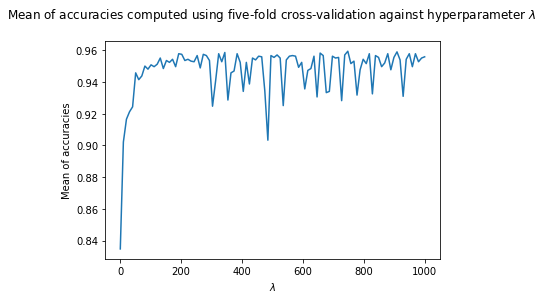

In [753]:
# Plotting mean of accuracies against different lambdas : SVM
plt.figure()
title = 'Mean of accuracies computed using five-fold cross-validation against hyperparameter $\lambda$ \n'
plt.title(title)
plt.xlabel('$\lambda$')
plt.ylabel('Mean of accuracies')
plt.plot(lambdas,accuracies)

The hyperparameter $\lambda$ balances the trade off that appears between having the largest minimum margin and having the minimum number of misclassified samples through the set. Namely, higher $\lambda$ is, higher we penalize misclassification and thus more we request a better fitting hyperplane. However, to some extent, having a better fitting of the hyperplane disables the possibility of having large margins between the two classes values, and further weakens the possibility of having a firm separation between the data. Having $\lambda$ small may increase said margins, however it is done at the price of some outlying misclassifications.

In this case, it seems that no suitable large margin can be found may $\lambda$ be small. Moreover, the accuracy is saturating for $\lambda > 75$, not increasing the performance further. 

### 2.3.2 Receiver operating characteristic on testing set

We now compute the performance of the model over the testing set for various hyperparameters. We display the results as a receiver operating characteristic curve. 

In [955]:
def getConfusionMatrixSVM(w, X_test, y_test) :
    """
    This function computes the confusion matrix for the given SVM on the given testing set.

    Parameters
    ----------
    w : an p-dimensionnal numpy array - the vector defining the hyperplane 
    X_test : an Nxp-dimensionnal numpy array - the predictors
    y_test : an N-dimensionnal numpy array - the targets

    Returns
    -------
    TP : an integer - the number of true positives
    TN : an integer - the number of true negatives
    FP : an integer - the number of false positives
    FN : an integer - the number of false negatives
    confusionMatrix : an 2x2-dimensionnal numpy array - the confusion matrix 
    """
    
    N = X_test.shape[0]
    
    
    TP = 0 # Positive is 'M' in our case
    TN = 0 # Negative is 'B' in our case
    FP = 0
    FN = 0
    
    y_pred = np.sign(X_test @ w)
    predictionsCorrectness = (y_pred==y_test)
    
    for i in range(N) :
        
        if predictionsCorrectness[i] and y_test[i] == 1.0 :
            TP += 1
        elif predictionsCorrectness[i] and y_test[i] == -1.0 :
            TN += 1
        elif not predictionsCorrectness[i] and y_test[i] == 1.0 :
            FN += 1
        elif not predictionsCorrectness[i] and y_test[i] == -1.0 :
            FP+= 1
    
    confusionMatrix = np.array([[TP, FP],[FN, TN]])
    
    return TP, TN, FP, FN, confusionMatrix
    

In [956]:
# Serializing the classes : 'M' becomes 1.0 and 'B' becomes -1.0
testingDataArray = df_tumour_test.to_numpy()
serialMap = {'M': 1.0, 'B': -1.0}
length = len(testingDataArray[:,31])
testingDataArray[:,31] = [serialMap[testingDataArray[i,31]] for i in range(length)]

# Standardization
testingDataArray[:,1:31] = (testingDataArray[:,1:31] - np.mean(testingDataArray[:,1:31])) \
/ np.std(testingDataArray[:,1:31])

# Augmenting dataArray to fit intercept 
testingDataArray = np.insert(testingDataArray, 31, 1, axis=1)

In [876]:
# Training the model with optimal lambda 
wBest = sgd(X = dataArray[:,1:32], y = dataArray[:,32], regul_strength = bestLambdaSVM, print_outcome=True)

Iteration is: 1, Cost is: 419.4174467053221
Iteration is: 2, Cost is: 381.9606339064277
Iteration is: 4, Cost is: 340.90094574857045
Iteration is: 8, Cost is: 174.86227086273485
Iteration is: 16, Cost is: 152.24745725178806
Iteration is: 32, Cost is: 127.83362705002139
Iteration is: 64, Cost is: 99.73397377931684
Iteration is: 128, Cost is: 108.32983304323041
Iteration is: 256, Cost is: 95.34086415231133
Iteration is: 512, Cost is: 104.78284232554064
Iteration is: 1024, Cost is: 95.09959043195151
Iteration is: 1999, Cost is: 96.49020235179567


In [957]:
# Computing confusion matrix on testing set
TP, TN, FP, FN, confusionMatrix = getConfusionMatrixSVM(w = wBest, X_test = testingDataArray[:,1:32], \
                                                        y_test = testingDataArray[:,32])
print(confusionMatrix)

[[ 48   0]
 [ 25 127]]


In [853]:
def ROC_SVM(X_train, y_train, X_test, y_test) :
    """
    This function computes the receiver operating characteristic curve values of the SVM model. 

    Parameters
    ----------
    X_train : an Nxp-dimensionnal numpy array - the train predictors
    y_train : an N-dimensionnal numpy array - the train targets
    X_test : an Nxp-dimensionnal numpy array - the test predictors
    y_test : an N-dimensionnal numpy array - the test targets

    Returns
    -------
    FPR : an M-dimensionnal numpy array - the false positive rates 
    TPR : an M-dimensionnal numpy array- the true positive rates
    """
    
    lambdas = np.linspace(start = 0.001, stop = 50000, num = 300) # Scanning lambdas
    
    FPR = np.zeros(lambdas.shape[0])
    TPR = np.zeros(lambdas.shape[0])
    
    for i, lbda in enumerate(lambdas) :
        
        # Training
        w = sgd(X = X_train, y = y_train, regul_strength = lbda)
        
        # Confusion matrix
        TP, TN, FP, FN, _ = getConfusionMatrixSVM(w = w, X_test = X_test, \
                                                        y_test = y_test)
        try : # Avoid divisions by zero
            FPR[i] = FP / (FP + TN) # False positive rate
            TPR[i] = TP / (TP + FN) # True positive rate
        except :
            FPR[i] = -1.0
            TPR[i] = -1.0
        
    FPR = FPR[FPR != -1.0] # Removing 
    TPR = TPR[TPR != -1.0]
        
    return FPR, TPR
    

In [958]:
# Computing best hyperparameter ROC point (FPR,TPR)
        
# Confusion matrix
bestTP, bestTN, bestFP, bestFN, _ = getConfusionMatrixSVM(w = wBest, X_test = testingDataArray[:,1:32], \
                                                        y_test = testingDataArray[:,32])

bestLbdaFPR = bestFP / (bestFP + bestTN) # False positive rate
bestLbdaTPR = bestTP / (bestTP + bestFN) # True positive rate

In [959]:
# Computing ROC
FPR, TPR = ROC_SVM(X_train = dataArray[:,1:32], y_train = dataArray[:,32], \
        X_test = testingDataArray[:,1:32], y_test = testingDataArray[:,32])

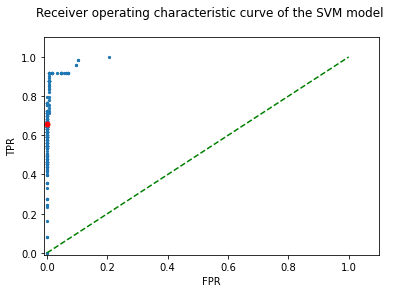

In [960]:
# Plotting ROC
plt.figure()
title = 'Receiver operating characteristic curve of the SVM model \n'
plt.title(title)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01,1.1])
plt.ylim([-0.01,1.1])
plt.plot([i for i in range(2)], [i for i in range(2)], color = 'green', ls = '--')
plt.scatter(FPR, TPR, s=5)
plt.scatter(bestLbdaFPR, bestLbdaTPR, s=25, color = 'red')

We display in red the pair (FPR,TPR) computed using our optimal hyperparameter. We are ideally seeking for the smallest false positive rate along with the greatest true positive rate possible. For our optimal $\lambda$, we have a false positive rate of 0, displaying the fact that no false positives arise from our predictions. Although the computed hyperparameter does not maximize the true positive rate for this given false positive rate level, the performance of the model remains fairly high, being substantially better than a uniform random selection process symbolized by the dashed line.  

### 2.3.3 Using balanced data

We now retrain our model on a balanced dataset and further compare its performance with our previously trained SVM model.

In [931]:
# Load balanced tumour data into a pandas dataframe 
df_tumour_bal = pd.read_csv("tumour_samples_bal.csv")
# Shuffling
df_tumour_bal = df_tumour_bal.sample(frac=1)
# Displaying the first five rows
df_tumour_bal.head()

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
627,627,12.087899,16.205290,87.017535,547.339343,0.086909,0.081002,0.051634,0.029736,0.167734,...,19.771306,92.575634,621.673267,0.136089,0.263930,0.328388,0.086810,0.294363,0.077496,B
159,159,14.999447,23.003345,90.973309,524.088231,0.089497,0.099329,0.053181,0.033369,0.170500,...,27.307626,115.205086,1082.041301,0.132672,0.320725,0.350721,0.143251,0.301848,0.098601,M
390,390,22.073516,17.604050,138.498180,1425.432345,0.091908,0.084731,0.098110,0.073845,0.164388,...,25.125070,196.732308,3150.579304,0.134453,0.163258,0.293642,0.194618,0.253306,0.064516,M
52,52,19.262679,19.147128,124.310868,1155.136280,0.116959,0.170659,0.249389,0.109277,0.204006,...,27.899546,173.840392,2327.501525,0.145617,0.356979,0.660332,0.226506,0.322246,0.091355,M
714,714,12.458203,21.399172,77.306696,454.998813,0.100990,0.097003,0.056405,0.030843,0.150244,...,29.517417,88.260510,555.457650,0.142491,0.233752,0.132008,0.080336,0.235747,0.089882,B


In [932]:
# Displaying the structure of this 'balanced' dataset
balDataArray = df_tumour_bal.to_numpy()
print('Number of M in balanced dataset = ' + str(list(balDataArray[:,31]).count('M')))
print('Number of B in balanced dataset = ' + str(list(balDataArray[:,31]).count('B')))

Number of M in balanced dataset = 400
Number of B in balanced dataset = 400


In [933]:
# Serializing the classes : 'M' becomes 1.0 and 'B' becomes -1.0
serialMap = {'M': 1.0, 'B': -1.0}
length = len(balDataArray[:,31])
balDataArray[:,31] = [serialMap[balDataArray[i,31]] for i in range(length)]

# Standardization
balDataArray[:,1:31] = (balDataArray[:,1:31] - np.mean(balDataArray[:,1:31])) / np.std(balDataArray[:,1:31])

# Augmenting dataArray to fit intercept 
balDataArray = np.insert(balDataArray, 31, 1, axis=1)

# Adding a row at the end to fit our fiveFoldValidationSVM function which drops the last row 
# In order for the set length to be dividable by 5, which is the case here without dropping last row
balDataArrayFF = np.insert(balDataArray, 800, 0, axis=0)

In [934]:
# Computing the optimal hyperparameter based on accuracy for balanced data
bestLambdaSVM_bal, lambdas, accuracies_bal, best_lambda_ind_bal = \
chooseBestLambdaSVM(dataArray = balDataArrayFF, returnArray = True)

Cross-validation for lambda = 0.001 gives a mean of accuracies = 0.5
Cross-validation for lambda = 151.51600000000002 gives a mean of accuracies = 0.67
Cross-validation for lambda = 303.031 gives a mean of accuracies = 0.7537499999999999
Cross-validation for lambda = 454.546 gives a mean of accuracies = 0.8887499999999999
Cross-validation for lambda = 606.061 gives a mean of accuracies = 0.88375
Cross-validation for lambda = 757.576 gives a mean of accuracies = 0.81125
Cross-validation for lambda = 909.091 gives a mean of accuracies = 0.8625


In [965]:
# Optimal lambda hyperparameter for SVM - Balanced data
print('Optimal λ = ' + str(bestLambdaSVM_bal))
# Corresponding mean of accuracies
print('Maximum mean of accuracies = ' + str(accuracies_bal[best_lambda_ind_bal]))

Optimal λ = 989.8990000000001
Maximum mean of accuracies = 0.9099999999999999


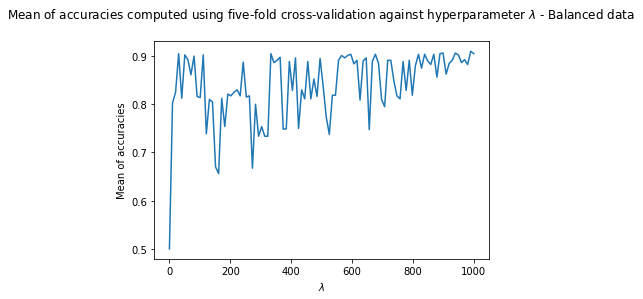

In [936]:
# Plotting mean of accuracies against different lambdas : SVM - Balanced data
plt.figure()
title = 'Mean of accuracies computed using five-fold cross-validation against hyperparameter $\lambda$ - Balanced data \n'
plt.title(title)
plt.xlabel('$\lambda$')
plt.ylabel('Mean of accuracies')
plt.plot(lambdas,accuracies_bal)

In [937]:
# Training the model with optimal lambda - Balanced data
wBest_bal = sgd(X = balDataArray[:,1:32], y = balDataArray[:,32],\
                regul_strength = bestLambdaSVM_bal, print_outcome=True)

Iteration is: 1, Cost is: 729.6589588140864
Iteration is: 2, Cost is: 749.6105160297783
Iteration is: 4, Cost is: 652.0789393115103
Iteration is: 8, Cost is: 513.080291567229
Iteration is: 16, Cost is: 337.45865886478305
Iteration is: 32, Cost is: 316.88312247139663
Iteration is: 64, Cost is: 270.95437577238783
Iteration is: 128, Cost is: 264.5983498250545
Iteration is: 256, Cost is: 234.0511697328188
Iteration is: 512, Cost is: 279.52731220367286
Iteration is: 1024, Cost is: 234.21883153299018
Iteration is: 1999, Cost is: 232.61187538655582


In [961]:
# Computing confusion matrix - Balanced data
TP_bal, TN_bal, FP_bal, FN_bal, confusionMatrix_bal = getConfusionMatrixSVM(w = wBest_bal, \
                                                                            X_test = testingDataArray[:,1:32], \
                                                        y_test = testingDataArray[:,32])
print(confusionMatrix_bal)

[[ 70  13]
 [  3 114]]


In [962]:
# Computing ROC - Balanced data
FPR_bal, TPR_bal = ROC_SVM(X_train = balDataArray[:,1:32], y_train = balDataArray[:,32], \
        X_test = testingDataArray[:,1:32], y_test = testingDataArray[:,32])

In [963]:
# Computing best hyperparameter ROC point (FPR,TPR) - Balanced data
        
# Confusion matrix
bestTP_bal, bestTN_bal, bestFP_bal, bestFN_bal, _ = getConfusionMatrixSVM(w = wBest_bal,\
                                                                          X_test = testingDataArray[:,1:32], \
                                                        y_test = testingDataArray[:,32])

bestLbdaFPR_bal = bestFP_bal / (bestFP_bal + bestTN_bal) # False positive rate
bestLbdaTPR_bal = bestTP_bal / (bestTP_bal + bestFN_bal) # True positive rate

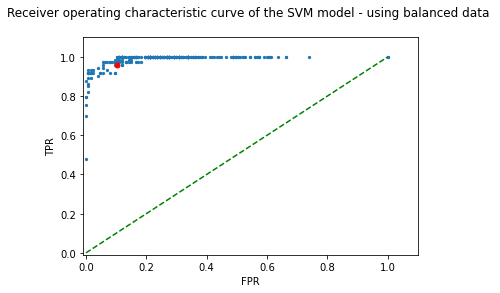

In [964]:
# Plotting ROC - Balanced data
plt.figure()
title = 'Receiver operating characteristic curve of the SVM model - using balanced data \n'
plt.title(title)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01,1.1])
plt.ylim([-0.01,1.1])
plt.plot([i for i in range(2)], [i for i in range(2)], color = 'green', ls = '--')
plt.scatter(FPR_bal, TPR_bal, s=5)
plt.scatter(bestLbdaFPR_bal, bestLbdaTPR_bal, s=25, color = 'red')

Training our SVM model on a balanced data set - that is to say on a data set where both classes are balanced in size - produces a receiver operating characteristic curve where optimal hyperparameters maintain the true positive rate to 1 (since no or little false negatives are predicted with said model). The relationship between the predictors and the true targets may perhaps be understood better by our model since such pairs occur more often in said balanced training dataset. Such a true positive rate can be achieved along with a rather good false positive rate (below 0.15). Notice also that for balanced data, the model performs rather similarly well than the unbalanced dataset, even though it has roughly 3 times less annotated training samples available (800 against 2566). As said previously, $\textit{having less false negatives for a little bit more of false positives is more acceptable in this medical context}$, and thus one may prefer this balanced training set for producing a better suited model. 

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Logistic regression and bagging  [^](#outline)

Once again, we seek to classify tumour samples that can belong to one of two given classes. We here use logistic regression to perform this task. Namely, we compute the probability of belonging to one of the classes by using the logistic function as follows : $P(y=1) = \frac{1}{1 + e^{-\mathbf{x}^T\mathbf{\beta}}}$. The vector $\beta$ is a parameter to be found by maximizing the log-likelihood : $L = \sum_i^N y^{(i)} \log h_{\beta}(\mathbf{x}^{(i)}) + (1-y^{(i)}) \log (1 - h_{\beta}(\mathbf{x}^{(i)}))$. Once a such $\beta$ has been found, we compute our predictions by using a threshold $\tau$ such that if $P(y=1|\mathbf{x}^{in}) > \tau$ then we have $\mathbf{x}^{in} = 1$.

### 3.1.1 Training 

We train this model on the same tumour samples training data set used previously. We approximate a vector $\beta$ maximizing the log-likelihood using graident descent. The threshold considered here is $\tau = 0.5$. 

Once again, we $\textbf{rely on the weekly coding tasks solutions}$, and further $\textbf{modify them to suit our current problem}$. 

In [1063]:
# In the weekly Coding Task solution functions, you may find my custom comments in the form of ### _____ ###

# Serializing the classes : 'M' becomes 1 and 'B' becomes 0
dataArray = df_tumour.to_numpy()
print(dataArray[:,31])
serialMap = {'M': 1, 'B': 0}
length = len(dataArray[:,31])
dataArray[:,31] = [serialMap[dataArray[i,31]] for i in range(length)]
print(dataArray[:,31])

# Standardization
dataArray[:,1:31] = (dataArray[:,1:31] - np.mean(dataArray[:,1:31])) / np.std(dataArray[:,1:31])

['B' 'B' 'B' ... 'B' 'B' 'B']
[0 0 0 ... 0 0 0]


In [1064]:
## SLIGHTLY MODIFYING THOSE CT4 SOLUTION FUNCTION ## 
### All 'slight modifications' proceed from small implementation differences between the CT and the coursework 
# to be fixed 
def logistic(x):
    x = x.astype(float)
    return 1. / (1. + np.exp(-x)) 

def predict_log(X, beta, beta_0):
  y_log = logistic(X.T @ beta + beta_0) 
  return y_log.squeeze()

In [1065]:
## SLIGHTLY MODIFYING THIS CT4 SOLUTION FUNCTION ## 

def initialise(d):
  """    
  Argument:
  d: size of the beta vector (or number of parameters)
  
  Returns:
  beta: initialised vector of shape (d, 1)
  beta_0: initialised scalar (corresponds to the offset)
  """
  
  beta = np.zeros(shape=(d, 1), dtype=np.float32)
  beta_0 = 0
  
  assert(beta.shape==(d, 1))
  assert(isinstance(beta_0, float) or isinstance(beta_0, int))
  
  return beta, beta_0

In [1066]:
## SLIGHTLY MODIFYING THIS CT4 SOLUTION FUNCTION ## 

def propagate(X, y, beta, beta_0):
  """
  Arguments:
  X: data of size (d, n)
  y: true label vector of size (1, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar

  Returns:
  cost: negative log-likelihood cost for logistic regression
  dbeta: gradient of the loss with respect to beta
  dbeta_0: gradient of the loss with respect to beta_0
  """
  n = X.shape[1]
  y_log = predict_log(X, beta, beta_0)

  # cost function
  cost = - (y * np.log(y_log) + (1-y) * np.log(1 - y_log)).mean()

  # derivatives
  dbeta = (X * (y_log - y)).mean(axis=1).reshape(-1, 1)
  dbeta_0 =  (y_log - y).mean() 

  assert(dbeta.shape==beta.shape)
  assert(type(dbeta_0)==float)
  cost = np.squeeze(cost)
  assert(cost.shape==())
  
  # store gradients in a dictionary
  grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
  return grads, cost

In [1067]:
## NOT MODIFYING THIS CT4 SOLUTION FUNCTION ## 

def optimise(X, y, beta, beta_0, num_iterations=5000, learning_rate=0.005, print_cost=False):
  """
  Arguments:
  X: data of size (d, n)
  y: true label vector of size (1, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar
  num_iterations: number of iterations gradient descent shall update the parameters
  learning_rate: step size in updating procedure
  print_cost: whether to print the cost every 500 iterations or not

  Returns:
  params: dictionary containing the parameters beta and offset beta_0
  grads: dictionary containing the gradients
  costs: list of all the costs computed during the optimisation (can be used to plot the learning curve).
  """
  costs = []
    
  for i in range(num_iterations):

      # calculate cost and gradients (hint: use your existing functions)
      grads, cost = propagate(X, y, beta, beta_0) 
      
      # retrieve derivatives from grads
      dbeta = grads["dbeta"]
      dbeta_0 = grads["dbeta_0"]
      
      # updating procedure
      beta = beta - learning_rate * dbeta  
      beta_0 = beta_0 - learning_rate * dbeta_0  
      
      # record the costs
      if i % 100 == 0:
          costs.append(cost)
      
      # print the cost every 500 iterations
      if print_cost and i % 500 == 0:
          print ("cost after iteration %i: %f" %(i, cost))
  
  # save parameters and gradients in dictionary
  params = {"beta": beta, "beta_0": beta_0}
  grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
  return params, grads, costs

In [1104]:
## SLIGHTLY MODIFYING THIS CT4 SOLUTION FUNCTION ## 

def predict(X_test, beta, beta_0):
  """
  Arguments:
  X_test: test data of size (d, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar

  Returns:
  y_pred: vector containing all binary predictions (0/1) for the examples in X_test
  y_log: vector containing the probabilities of belonging to each classes 
  """
  n = X_test.shape[1]
  y_pred = np.zeros((1,n))
  beta = beta.reshape(X_test.shape[0], 1)
  
  # compute vector y_log predicting the probabilities
  y_log = predict_log(X_test, beta, beta_0)
  
  ### Rounding - Equivalent to having a threshold tau = 0.5 ###
  y_pred = y_log.round().reshape(1, -1) 
  
  assert(y_pred.shape==(1, n))
  
  return y_pred, y_log

We here use $\texttt{np.round()}$ which rounds the probabilities to the closest integer. This process is equivalent to setting a threshold $\tau = 0.5$. 

In [1080]:
test = np.array([0.1,0.7,0.5,0.1,0.9])
test.round()

array([0., 1., 0., 0., 1.])

In [1069]:
# Computing beta on training set 
initialBeta, initialBeta0 = initialise(dataArray[:,1:31].shape[1])
params, grads, costs = optimise(X = dataArray[:,1:31].T, y = dataArray[:,31],\
                                beta = initialBeta, beta_0 = initialBeta0, \
                                num_iterations=5000, \
                                learning_rate=0.005, print_cost = True)

cost after iteration 0: 0.693147
cost after iteration 500: 0.425759
cost after iteration 1000: 0.333783
cost after iteration 1500: 0.285486
cost after iteration 2000: 0.255836
cost after iteration 2500: 0.235765
cost after iteration 3000: 0.221255
cost after iteration 3500: 0.210259
cost after iteration 4000: 0.201628
cost after iteration 4500: 0.194667


In [1105]:
def accuracyLogisticReg(X_train, y_train, X_test, y_test,  num_iterations=5000, learning_rate=0.005) :
    """
    This function computes the accuracy of the logistic regression model on a testing set.

    Parameters
    ----------
    X_train : an pxN-dimensionnal numpy array - the train predictors
    y_train : an N-dimensionnal numpy array - the train targets
    X_test : an pxN-dimensionnal numpy array - the test predictors
    y_test : an N-dimensionnal numpy array - the test targets
    num_iterations : an integer - the maximum number of iterations for the gradient descent 
    learning_rate : a float number - the step size of the gradient descent 

    Returns
    -------
    accuracy : a float number - the accuracy of the model
    """
    
    # Initializing our parameter
    initialBeta, initialBeta0 = initialise(X_train.shape[0])
    
    # Training 
    parameters, grads, costs = optimise(X = X_train, y = y_train, \
                                        beta = initialBeta, beta_0 = initialBeta0, \
                                        num_iterations = num_iterations, \
                                        learning_rate = learning_rate)
    beta = parameters["beta"]
    beta0 = parameters["beta_0"]
    
    # Predicting
    yPredictions, _ = predict(X_test, beta, beta0)

    # Accuracy
    accuracy = 100 - np.mean(np.abs(yPredictions - y_test)) * 100 # Taken from CT4
    
    return accuracy 

In [1113]:
# Serializing the classes : 'M' becomes 1 and 'B' becomes 0
testingDataArray = df_tumour_test.to_numpy()
serialMap = {'M': 1, 'B': 0}
length = len(testingDataArray[:,31])
testingDataArray[:,31] = [serialMap[testingDataArray[i,31]] for i in range(length)]

# Standardization
testingDataArray[:,1:31] = (testingDataArray[:,1:31] - np.mean(testingDataArray[:,1:31])) \
/ np.std(testingDataArray[:,1:31])

In [1114]:
# Accuracy on testing data
accuracyLR = accuracyLogisticReg(X_train = dataArray[:,1:31].T, y_train = dataArray[:,31], \
          X_test = testingDataArray[:,1:31].T, y_test = testingDataArray[:,31])
print('Accuracy of our logistic regression model = ' + str(accuracyLR))

Accuracy of our logistic regression model = 82.5


### 3.1.2 Bagging and logistic regression

We now use the bagging process to improve our method, that is to say we draw $B$ random samples with replacement from our training dataset and we further train the model on each of said samples. We obtain $B$ vectors $\beta_b$, which further gives us $B$ probability vectors for each new entry value to predict. We aggregate those probability vectors by computing their average. We then use the same threshold $\tau = 0.5$ on this average vector to obtain our classification prediction.

We use the 5-fold cross-validation process to find the optimal number of bootstrap samples $B$.

In [ ]:
def accuracyLogisticRegBagging(X_train, y_train, X_test, y_test, B, \
                               num_iterations=5000, learning_rate=0.005) :
    """
    This function computes the accuracy of the logistic regression model on a testing set, using the 
    bagging process.

    Parameters
    ----------
    X_train : an pxN-dimensionnal numpy array - the train predictors
    y_train : an N-dimensionnal numpy array - the train targets
    X_test : an pxN-dimensionnal numpy array - the test predictors
    y_test : an N-dimensionnal numpy array - the test targets
    B : an integer - the number of bootstrap samples
    num_iterations : an integer - the maximum number of iterations for the gradient descent 
    learning_rate : a float number - the step size of the gradient descent 

    Returns
    -------
    accuracy : a float number - the accuracy of the model
    """
    # Retreiving N
    N = X_train.shape[1]
    # Indices in X_train
    training_indices = np.arange(N)
    
    # Number of elements per sample
    sampleSize = N//2 # This could be another hyperparameter to fine tune 
    
    # Vector containing the aggregate of probabilities 
    meanYlog = np.zeros(X_test.shape[1])
    
    for _ in range(B) :
        
        # Sampling - Size of samples is N//2
        sample = np.random.choice(training_indices, sampleSize, replace=True) # Taken from CT6
        X_sample = X_train[: , sample]
        y_sample = y_train[sample] 
        
    
        # Initializing our parameter
        initialBeta, initialBeta0 = initialise(X_sample.shape[0])

        # Training 
        parameters, grads, costs = optimise(X = X_sample, y = y_sample, \
                                            beta = initialBeta, beta_0 = initialBeta0, \
                                            num_iterations = num_iterations, \
                                            learning_rate = learning_rate)
        beta = parameters["beta"]
        beta0 = parameters["beta_0"]

        # Predicting
        _, y_log = predict(X_test, beta, beta0)
        
        # Aggregating 
        meanYlog += y_log
    
    # Discretization
    meanYlog = (1/B) * meanYlog
    yPredictions = meanYlog.round().reshape(1, -1) 

    # Accuracy
    accuracy = 100 - np.mean(np.abs(yPredictions - y_test)) * 100 # Taken from CT4
    
    return accuracy

Notice that we chose here to set the samples size to $\texttt{N//2}$. This choice is arbitrary and this hyperparameter could be fine tuned also using a cross-validation process.  

In [1120]:
accuracyLRwBagging = accuracyLogisticRegBagging(X_train = dataArray[:,1:31].T, y_train = dataArray[:,31], \
          X_test = testingDataArray[:,1:31].T, y_test = testingDataArray[:,31], B = 3)
print('Accuracy of our logistic regression model with bagging (B=3) = ' + str(accuracyLRwBagging))

Accuracy of our logistic regression model with bagging (B=3) = 82.5


In [1121]:
def fiveFoldValidationLR(dataArray, B) :
    """
    This function computes the mean of accuracies of a five-fold cross-validation 
    of the logistic regression model with bagging.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    B : an integer - the number of bootstrap samples

    Returns
    -------
    meanAccuracy : a float number - the mean of accuracies of the five-fold cross-validation 
    """
    
    accuracies = np.zeros(5) # Container for the accuracies 

    # As seen in coding task - List of five index arrays, each correspond to one of the five folds.
    folds_indexes = np.split(np.arange(dataArray.shape[0]-1), 5) # We drop the last one to allow division by 5
    
    for i in range(5) : # Five fold

        # Building validation subset
        validationSubset  = dataArray[folds_indexes[i]] 
        training_indexes = [] # Initializing 
        # Building training subset
        for j in range(5) :
            if j != i : 
                training_indexes += list(folds_indexes[j])
        trainingSubset = dataArray[training_indexes]
        
        
        # Training and Validation
        # On training subset
        # On validation subset
        accuracies[i] = accuracyLogisticRegBagging(X_train = trainingSubset[:,1:31].T, \
                                                   y_train = trainingSubset[:,31].T, \
                                                   X_test = validationSubset[:,1:31].T, \
                                                   y_test = validationSubset[:,31].T, \
                                                   B = B)
         
    
    return np.mean(accuracies)

In [1130]:
def chooseBestBlogisticReg(dataArray, returnArray = False):
    """
    This function computes the optimal hyperparameter B by using a five-fold cross-validation
    method for the logistic regression with bagging.

    Parameters
    ----------
    dataArray : an Nx(p+2)-dimensionnal numpy array containing both the predictors and the target value
    returnArray : boolean value - if set to True the function returns the arrays containing the means 
        of accuracies and the tested B 

    Returns
    -------
    best_B : an integer - the optimal hyperparameter
    Blist : an M-dimensionnal numpy array containing the tested B
    BAcc : an M-dimensionnal numpy array containing the means of accuracies
    best_B_ind : an integer - the optimal B index in Blist
    
    """
    # Initialization
    Blist = np.arange(start = 2, stop = 30, step = 3) # Scanning B
    accuracies = np.zeros(Blist.shape[0])
    
    for i, B in enumerate(Blist) :
        # Maximizing mean of accuracies
        accuracies[i] = fiveFoldValidationLR(dataArray = dataArray, B = B)
        print('Cross-validation for B = ' + str(B) + ' gives a mean of accuracies = '\
                  + str(accuracies[i]))
        
    best_B_ind = np.argmax(accuracies) # A maximizer of means of accuracies
    
    if returnArray :
        return Blist[best_B_ind], Blist, accuracies, best_B_ind
    
    return Blist[best_B_ind]

In [1132]:
bestB, Blist, accuracies, best_B_ind = chooseBestBlogisticReg(dataArray = dataArray, returnArray = True)

Cross-validation for B = 2 gives a mean of accuracies = 94.11306042884989
Cross-validation for B = 5 gives a mean of accuracies = 94.07407407407406
Cross-validation for B = 8 gives a mean of accuracies = 94.26900584795322
Cross-validation for B = 11 gives a mean of accuracies = 94.19103313840155
Cross-validation for B = 14 gives a mean of accuracies = 93.99610136452242
Cross-validation for B = 17 gives a mean of accuracies = 94.15204678362572
Cross-validation for B = 20 gives a mean of accuracies = 94.15204678362572
Cross-validation for B = 23 gives a mean of accuracies = 94.03508771929823
Cross-validation for B = 26 gives a mean of accuracies = 93.9961013645224
Cross-validation for B = 29 gives a mean of accuracies = 93.95711500974657


In [1133]:
# Optimal B hyperparameter for logistic regression with bagging
print('Optimal B = ' + str(bestB))
# Corresponding mean of accuracies
print('Maximum mean of accuracies = ' + str(accuracies[best_B_ind]))

Optimal B = 8
Maximum mean of accuracies = 94.26900584795322


### 3.1.3

We now compare the accuracy obtained by the model with and without bagging, on the testing set, while using our optimal parameter $B=8$. 

In [1134]:
accuracyLR = accuracyLogisticReg(X_train = dataArray[:,1:31].T, y_train = dataArray[:,31], \
          X_test = testingDataArray[:,1:31].T, y_test = testingDataArray[:,31])
print('Accuracy of our logistic regression model = ' + str(accuracyLR))

Accuracy of our logistic regression model = 82.5


In [1135]:
accuracyLRwBaggingBestB = accuracyLogisticRegBagging(X_train = dataArray[:,1:31].T, y_train = dataArray[:,31], \
          X_test = testingDataArray[:,1:31].T, y_test = testingDataArray[:,31], B = bestB)
print('Accuracy of our logistic regression model with bagging (B=8) = ' + str(accuracyLRwBaggingBestB))

Accuracy of our logistic regression model with bagging (B=8) = 83.0


As we compute the predictions using the logistic regression model on the full training set we obtain an accuracy close to 94%. However, the accuracy computed on the unused testing set is rather lower (82.5%). This might highlight an overfitting of the model on the training data. We further use a bagging process, randomly sampling the training data and then aggregating the results in order to reduce the variability arising from any new entry data. Even though the accuracy obtained using bagging is better (83%), applying this method does not improve substantially the performance of our model on unseen data. Thus, one may prefer using one of our better performing previously seen models (SVM, Random forests).  

<a name="q32"></a>

## 3.2 Kernelised SVM classifier [^](#outline)

We now perform the same classification task, again using a soft margin SVM, this time implementing a kernelised version of the method. Namely, we replace the dot products involved in the optimisation process of the classic SVM method by a non-linear kernel function. The kernel function maps two vectors to the dot product of a pair of nonlinearly transformed vectors of higher-dimension. The idea is to lift our data to a higher dimensional space, in which a separating hyperplane can be found with low penalties. In pratice, we choose those kernel functions such that we only have to compute a function of the usual dot-product. 

The kernel function we consider here is the Gaussian radial basis function given by $k(\mathbf{x},\mathbf{y}) = e^{\frac{-||\mathbf{x}-\mathbf{y}||^2}{\sigma}}$. 

In this new setting, we are seeking to minimize : $\min_{\mathbf{\omega_z}} \frac{1}{2}||\mathbf{\omega_z}||^2 + \frac{\lambda}{N} \sum_i^N \max(0,1-y^{(i)}(\mathbf{\omega_z}\cdot\mathbf{z}^{(i)}+b))$, where $\mathbf{\omega_z}\cdot\mathbf{z}^{(i)} = k(\mathbf{\omega},\mathbf{x}^{(i)})$. 

### 3.2.1 Implementation

Notice that $||\mathbf{\omega_z}||^2 = \mathbf{\omega_z} \cdot \mathbf{\omega_z} = k(\mathbf{\omega},\mathbf{\omega}) = 1$. We thus seek to minimize : $\sum_i^N \max(0,1-y^{(i)}(k(\mathbf{\omega},\mathbf{x}^{(i)})+b))$. The gradient sums either zeros or terms of the form $-\frac{2}{\sigma}y^{(i)}k(\mathbf{\omega},\mathbf{x}^{(i)})(\mathbf{\omega}-\mathbf{x}^{(i)}) $.

We modify the functions implemented previously, and we build several new helper functions to perform this task.

In [1291]:
# In the weekly Coding Task solutions functions, you may find my custom comments in the form of ### _____ ###

# Serializing the classes : 'M' becomes 1.0 and 'B' becomes -1.0
dataArray = df_tumour.to_numpy()
serialMap = {'M': 1.0, 'B': -1.0}
length = len(dataArray[:,31])
dataArray[:,31] = [serialMap[dataArray[i,31]] for i in range(length)]

# Standardization
dataArray[:,1:31] = (dataArray[:,1:31] - np.mean(dataArray[:,1:31])) / np.std(dataArray[:,1:31])

# Augmenting dataArray to fit intercept 
#dataArray = np.insert(dataArray, 31, 1, axis=1)

In [1138]:
def ker(x,y,sigma) :
    """
    This function computes the Gaussian radial basis kernel function.
    
    Parameters
    ----------
    x : an M-dimensionnal numpy array - a vector
    y : an M-dimensionnal numpy array - a vector
    sigma : a float number - a hyperparameter


    Returns
    -------
    ker : a float number - the value of the Gaussian radial basis kernel function
    
    """
    
    return np.exp(-(np.linalg.norm(x-y)**2)/sigma)

In [1255]:
## MODIFYING THIS CT7 SOLUTION FUNCTION ## 

def compute_cost(w, X, y, sigma):
    n = X.shape[0]
    distances = np.zeros(n)
    for i in range(n) :
        distances[i] = 1 - y[i] * (ker(X[i],w[1:],sigma) + w[0]) ### Using ker ###
    distances[distances < 0] = 0  # equivalent to max(0, distance)

    # calculate cost
    return np.sum(distances)

In [1309]:
## MODIFYING THIS CT7 SOLUTION FUNCTION ## 

# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, sigma):
    # if only one example is passed
    y_batch = np.asarray([y_batch])
    X_batch = np.asarray([X_batch])  # gives multidimensional array

    #distance = 1 - (y_batch * (X_batch @ w))
    n = X_batch.shape[0]
    distances = np.zeros(n)
    for i in range(n) :
        distances[i] = 1 - y_batch[i] * ker(X_batch[i],w[1:],sigma) ### Using ker ###
    dw = np.zeros(len(w), dtype = float)

    for ind, d in enumerate(distances):
        if max(0, d)!=0:
            #di = w - (regul_strength * y_batch[ind] * X_batch[ind])
            ### Not efficient ###
            ### Using ker ###
            di = np.zeros(len(w), dtype = float)
            di[1:] = -(2/sigma) * y_batch[ind] * ker(X_batch[ind],w[1:],sigma) * (w[1:] - X_batch[ind])
            di[0] = -y_batch[ind]
            di = di.astype(float)
            dw += di

    return dw/len(y_batch)  # average

In [1306]:
## MODIFYING THIS CT7 SOLUTION FUNCTION ## 

def sgd(X, y, batch_size=32, max_iterations=5000, stop_criterion=1e-20, \
        learning_rate=1e-5, sigma=1, print_outcome=False):
    # initialise zero weights
    weights = np.zeros(X.shape[1]+1)
    #np.random.uniform(size=X.shape[1]+1)
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, sigma) ### Using sigma ###
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, sigma) ### Using sigma ###
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

In [1311]:
# Training the model 
w = sgd(X = dataArray[:,1:31], y = dataArray[:,31], sigma=0.000001, print_outcome=True)
print("Training finished.")

Iteration is: 1, Cost is: 2565.55332
Iteration is: 2, Cost is: 2565.10664
Iteration is: 4, Cost is: 2564.52252
Iteration is: 8, Cost is: 2563.1824800000004
Iteration is: 16, Cost is: 2560.2962399999997
Iteration is: 32, Cost is: 2554.1458000000002
Iteration is: 64, Cost is: 2542.257240000001
Iteration is: 128, Cost is: 2518.651920000001
Iteration is: 256, Cost is: 2472.57515999999
Iteration is: 512, Cost is: 2377.6384800000174
Iteration is: 1024, Cost is: 2188.349239999864
Iteration is: 2048, Cost is: 1808.2245599994835
Iteration is: 4096, Cost is: 1056.0154400023453
Iteration is: 4999, Cost is: 877.9343999993837
Training finished.


In [1316]:
## MODIFYING THIS CT7 SOLUTION FUNCTION ## 

### Using accuracy ###
def score(w, X, y, sigma):
    n = X.shape[0]
    y_preds = np.zeros(n)
    for i in range(n) :
        y_preds[i] = np.sign(ker(X[i],w[1:],sigma) + w[0]) ### Using ker ###
    return np.mean(y_preds == y)

In [1317]:
score(w, X = dataArray[:,1:31], y = dataArray[:,31], sigma = 0.000001)

0.8347622759158223

In [1296]:
# Serializing the classes : 'M' becomes 1.0 and 'B' becomes -1.0
testingDataArray = df_tumour_test.to_numpy()
serialMap = {'M': 1.0, 'B': -1.0}
length = len(testingDataArray[:,31])
testingDataArray[:,31] = [serialMap[testingDataArray[i,31]] for i in range(length)]

# Standardization
testingDataArray[:,1:31] = (testingDataArray[:,1:31]\
                            - np.mean(testingDataArray[:,1:31])) / np.std(testingDataArray[:,1:31])

# Augmenting dataArray to fit intercept 
#dataArray = np.insert(dataArray, 31, 1, axis=1)